# Imports


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from visualize import visualize
from statsmodels.tsa.stattools import acf
from pylab import rcParams
import statsmodels.api as sm
import datetime as dt
import time as time
from loc_utils import utilities

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

# models
from sklearn.ensemble import RandomForestRegressor

# optimization and hyperparameters
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# model evaluation
from sklearn.metrics import mean_squared_error

# Reading Data


In [2]:
df = pd.read_excel(f"../data/raw/Powerol_Data_ML_v3.xlsx")

In [3]:
df.head()

,KVA,Enquiry,Book,SaleInvoice,enquiryDate,SalesOrderDate,InvoiceDate,OEMName,StateName,Region,DealerId,DealerName
0,5.0,1,NaN,0,2023-01-14 11:59:00,NaT,NaT,NaN,NaN,NaN,NaN,NaN
1,5.0,1,NaN,0,2019-02-11 12:20:00,NaT,NaT,NaN,NaN,NaN,NaN,NaN
2,5.0,1,NaN,0,2020-10-22 08:19:00,NaT,NaT,NaN,NaN,NaN,NaN,NaN
3,5.0,1,NaN,0,2024-01-22 16:08:00,NaT,NaT,NaN,NaN,NaN,NaN,NaN
4,5.0,1,NaN,0,2020-12-17 13:55:00,NaT,NaT,NaN,NaN,NaN,NaN,NaN


---


# Data Understanding


In [4]:
df.shape

(433906, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433906 entries, 0 to 433905
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   KVA             433673 non-null  float64       
 1   Enquiry         433906 non-null  int64         
 2   Book            112397 non-null  float64       
 3   SaleInvoice     433906 non-null  int64         
 4   enquiryDate     433906 non-null  datetime64[ns]
 5   SalesOrderDate  112397 non-null  datetime64[ns]
 6   InvoiceDate     86455 non-null   datetime64[ns]
 7   OEMName         18 non-null      object        
 8   StateName       106177 non-null  object        
 9   Region          106177 non-null  object        
 10  DealerId        130501 non-null  float64       
 11  DealerName      130501 non-null  object        
dtypes: datetime64[ns](3), float64(3), int64(2), object(4)
memory usage: 39.7+ MB


In [6]:
df.isnull().sum()

KVA                  233
Enquiry                0
Book              321509
SaleInvoice            0
enquiryDate            0
SalesOrderDate    321509
InvoiceDate       347451
OEMName           433888
StateName         327729
Region            327729
DealerId          303405
DealerName        303405
dtype: int64

In [7]:
df.describe()

,KVA,Enquiry,Book,SaleInvoice,enquiryDate,SalesOrderDate,InvoiceDate,DealerId
count,433673.000000,4.339060e+05,112397.000000,433906.000000,433906,112397,86455,130501.000000
mean,11.408310,6.227962e+03,1.518786,0.211721,2021-05-09 10:38:38.399192320,2022-03-03 21:47:20.840947712,2022-02-26 00:16:02.387369216,369.696592
min,1.000000,1.000000e+00,0.000000,0.000000,1979-08-18 00:00:00,2016-03-30 00:00:00,2016-03-21 00:00:00,1.000000
25%,5.000000,1.000000e+00,1.000000,0.000000,2019-12-14 13:04:00,2020-09-21 00:00:00,2020-10-07 00:00:00,230.000000
50%,8.000000,1.000000e+00,1.000000,0.000000,2022-01-05 10:05:30,2022-05-23 00:00:00,2022-04-28 00:00:00,447.000000
75%,16.000000,1.000000e+00,1.000000,0.000000,2023-07-25 15:11:45,2023-08-28 00:00:00,2023-07-31 00:00:00,522.000000
max,73.000000,1.911527e+09,4624.000000,68.000000,2024-12-11 23:08:00,2024-12-11 00:00:00,2024-12-11 00:00:00,671.000000
std,9.520609,3.139566e+06,19.057120,0.526962,NaN,NaN,NaN,189.599773


---

### 1. KVA


In [8]:
df["KVA"].unique()

array([ 5., 13.,  6.,  7.,  8., 18.,  3., 10., 16.,  1., 23.,  9., 11.,
       22., 20., 17., 25., 28., 73., 12., 27.,  2., 15., 31., 21., 30.,
        4., 33., 19., 26., 14., 35., 34., 32., 29., 37., 36., 41., nan,
       24., 38.])

In [9]:
df["KVA"].nunique()

40

<b>Given</b>

- There are a total of 29 Generators as given in the list below: <br>
  - 5kVA, 10kVA, 15kVA, 20kVA, 25kVA, 25 kVA (Gas Genset), 30kVA, 40kVA, 62.5kVA, 75kVA, 82.5kVA, 100kVA, 125kVA, 125 kVA (Gas Genset), 180kVA, 200kVA, 250kVA, 320kVA, 400kVA, 500kVA, 625kVA, 12.5kVA, 18.5kVA, 22.5kVA, 35kVA, 45kVA, 50kVA, 55kVA, 70kVA

---

🔬<b>Observations</b>

- But there are total 40 unique KVA's in our data: <br>

  - [ 5., 13., 6., 7., 8., 18., 3., 10., 16., 1., 23., 9., 11.,
    22., 20., 17., 25., 28., 73., 12., 27., 2., 15., 31., 21., 30.,
    4., 33., 19., 26., 14., 35., 34., 32., 29., 37., 36., 41., nan,
    24., 38.]

- Not to be confused with the actual KVAs, because these are KVA IDs
- One of them is NaN and it appears 233 times in the dataset (check if there are any SalesInvoice against these else we will be droppping these rows)


In [9]:
print(
    "There are",
    len(df[(df["KVA"].isnull()) & (df["SaleInvoice"] > 0)]),
    "sales for null KVAs",
)

There are 0 sales for null KVAs


In [10]:
# ⚡Let's drop these rows, as they do not add value to our analysis.
indices_null_kvas = df[(df["KVA"].isnull())].index
print("Dropping:", len(indices_null_kvas), "rows")
df = df.drop(indices_null_kvas)

Dropping: 233 rows


In [11]:
df.shape

(433673, 12)

In [12]:
# Also let's convert these KVA numbers to KVA Product IDs
df["KVA_Id"] = df["KVA"].apply(lambda x: f"P{int(x)}")
df.drop(columns=["KVA"], inplace=True)

In [13]:
df[303117:].head()

,Enquiry,Book,SaleInvoice,enquiryDate,SalesOrderDate,InvoiceDate,OEMName,StateName,Region,DealerId,DealerName,KVA_Id
303250,2,NaN,0,2020-10-24 10:39:00,NaT,NaT,NaN,NaN,NaN,521.0,Escon Gensets Private Limited,P10
303251,2,NaN,0,2022-12-05 16:59:00,NaT,NaT,NaN,NaN,NaN,595.0,MARUTI INDUSTRIES,P23
303252,2,NaN,0,2019-12-02 16:46:00,NaT,NaT,NaN,NaN,NaN,557.0,Sri sai infra equipment pvt ltd,P28
303253,2,NaN,0,2023-05-04 19:50:00,NaT,NaT,NaN,NaN,NaN,632.0,Bansal Brothers,P25
303254,2,NaN,0,2020-06-02 12:44:00,NaT,NaT,NaN,NaN,NaN,521.0,Escon Gensets Private Limited,P23


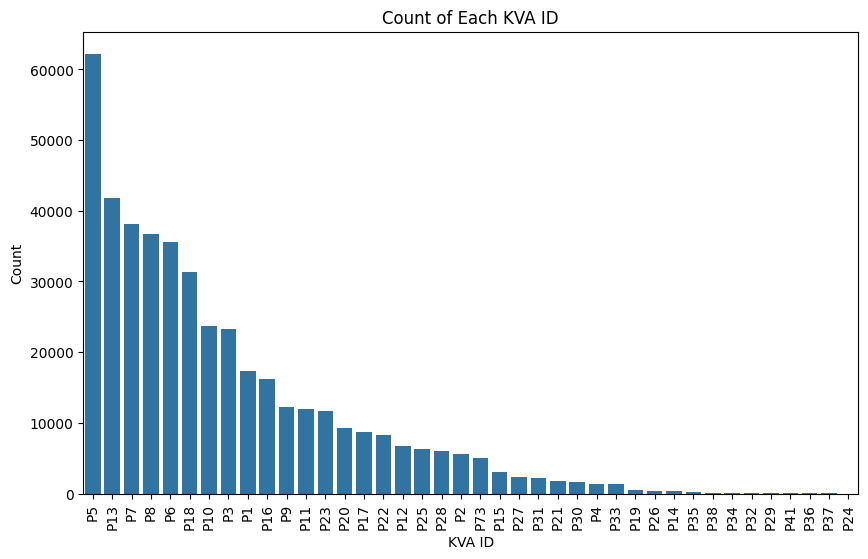

In [14]:
visualize.countplot_kva(df)

---

### 2. Book


In [15]:
print("There are", df["Book"].isnull().sum(), "nulls in the book column")
print("There are", len(df[df["Book"] == 0]), "0's in the book column")

There are 321376 nulls in the book column
There are 22 0's in the book column


In [16]:
df["Book"] = df["Book"].fillna(0)
len(df[df["Book"] == 0])

321398

This means that 321398 enquiries were never converted to bookings and further Sales


In [17]:
print(
    "Percentage of Enquiries converted to Bookings: ",
    ((sum(df["Book"]) / sum(df["Enquiry"])) * 100),
    "%",
)

Percentage of Enquiries converted to Bookings:  0.006271597808941096 %


---

### 3. Sales


In [18]:
print(
    "Percentage of Bookings converted to Sales: ",
    ((sum(df["SaleInvoice"]) / sum(df["Book"])) * 100),
    "%",
)

Percentage of Bookings converted to Sales:  54.20649531497085 %


---

### 4. OEM Name


In [19]:
print("Total OEMs in the dataset:", len(df[~df["OEMName"].isnull()]))

Total OEMs in the dataset: 18


In [20]:
df[~df["OEMName"].isnull()]

,Enquiry,Book,SaleInvoice,enquiryDate,SalesOrderDate,InvoiceDate,OEMName,StateName,Region,DealerId,DealerName,KVA_Id
322362,1,1.0,0,2022-12-26 15:55:00,2022-12-26,NaT,MAHINDRA AND MAHINDRA LIMITED,Uttar Pradesh,North1,611.0,PRIME POWER GENERATORS PVT LTD. Chennai,P1
322363,1,1.0,0,2024-11-20 17:28:00,2024-12-11,NaT,Shyam Global Technoventures Pvt Ltd,Goa,West,587.0,POWERSAFE ENGINEERS,P7
322364,1,1.0,0,2024-12-11 16:45:00,2024-12-11,NaT,Perfect Generators Technologies Pvt. Ltd.,NaN,NaN,230.0,Perfect Generators Technologies Pvt. Ltd.,P11
322365,1,1.0,0,2024-12-07 17:27:00,2024-12-11,NaT,Tanwar Industries,Rajasthan,North1,380.0,Tanwar Industries,P18
322366,1,1.0,0,2024-12-10 16:58:00,2024-12-10,NaT,Southern Gensets,Kerala,South,449.0,Gentech Power Systems,P11
322367,1,1.0,0,2024-12-11 13:32:00,2024-12-11,NaT,Sharda Diesels Pvt Ltd,Bihar,East,351.0,Agro Power Equipment,P73
322368,1,1.0,0,2024-12-11 15:34:00,2024-12-11,NaT,Recon Technologies Pvt Ltd,Telangana,South,143.0,Recon Technologies Pvt. Ltd,P5
322369,1,1.0,0,2024-12-10 16:00:00,2024-12-10,NaT,Gangadhar Industries,Gujarat,West,46.0,Gangadhar Industries,P20
322370,1,1.0,0,2024-12-11 16:34:00,2024-12-11,NaT,GSP Power Projects retail Division,Orissa,East,454.0,Gurukurpa Generators,P5
322371,1,1.0,0,2024-12-11 18:26:00,2024-12-11,NaT,Escon Gensets Private Limited,Gujarat,West,521.0,Escon Gensets Private Limited,P5


⚡As there are only 18 rows contaning information about OEMs, we will be removing the column completely


In [21]:
df.drop(columns=["OEMName"], inplace=True)

---

### 5. State Name


In [22]:
df["StateName"].nunique()

36

In [23]:
df["StateName"].unique()

array([nan, 'Gujarat', 'Assam', 'Jammu & Kashmir', 'Goa',
       'Madhya Pradesh', 'Rajasthan', 'Uttar Pradesh', 'Telangana',
       'Kerala', 'Nagaland', 'Karnataka', 'Tamil Nadu', 'Maharashtra',
       'Andhra Pradesh', 'Bihar', 'Jharkhand', 'Manipur', 'Haryana',
       'Uttarakhand', 'Delhi', 'Chhattisgarh', 'Punjab', 'Meghalaya',
       'Arunachal Pradesh', 'West Bengal', 'Orissa', 'Puducherry',
       'Andaman & Nicobar Islands', 'Mizoram', 'Tripura', 'Chandigarh',
       'Daman & Diu', 'Dadra and Nagar Haveli', 'Sikkim',
       'Himachal Pradesh', 'Lakshadweep'], dtype=object)

🔬The above list contatins the names of states as well as union territories (except for Ladakh):<br>
UTs: Andaman and Nicobar Islands,
Chandigarh,
Dadra and Nagar Haveli and Daman and Diu,
Delhi,
Jammu and Kashmir,
Ladakh,
Lakshadweep,
Puducherry

---


In [24]:
len(df) - df["StateName"].isnull().sum()

np.int64(106088)

---

### 6. Region


In [25]:
df["Region"].unique()

array([nan, 'West', 'East', 'North1', 'South'], dtype=object)

In [26]:
len(df) - df["Region"].isnull().sum()

np.int64(106088)

---

### 7. Dealer Name & Dealer Id


In [27]:
df["DealerName"].nunique()

261

In [28]:
len(df) - df["DealerName"].isnull().sum()

np.int64(130501)

In [29]:
df["DealerId"].nunique()

261

In [30]:
df["DealerId"].isnull().sum()

np.int64(303172)

In [31]:
len(df[(df["DealerId"].isnull()) & (df["SaleInvoice"] == 0)])

303172

In [32]:
len(df[(df["DealerId"].isnull()) & (df["Book"] == 0)])

302982

🔬

- We can clearly observe that places where Dealer ID and Dealer Name are blank, the SaleInvoice Quantity is also 0. These might be enquiries that might have come online.
- We can also see that some of them have still gotten booked, but ultimately "Sale" matters.

---

⚡Since we have no information regarding the Dealers, we will be dropping these rows.


In [33]:
df = df[~df["DealerId"].isnull()]

In [34]:
df.shape

(130501, 11)

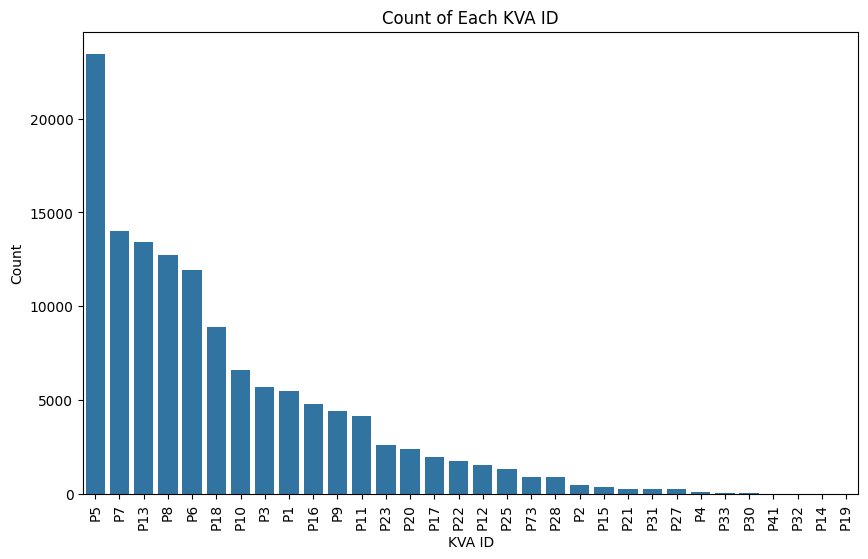

In [35]:
visualize.countplot_kva(df)

🔬We can see that demand for P5 is still higher though the overall count has decreased.

⚡Let's take P5 for our initial forecasting


# 📈 Analysis of P5


In [36]:
df_p5 = df[df["KVA_Id"] == "P5"]

In [37]:
df_p5.head()

,Enquiry,Book,SaleInvoice,enquiryDate,SalesOrderDate,InvoiceDate,StateName,Region,DealerId,DealerName,KVA_Id
303136,2,0.0,0,2020-06-25 00:00:00,NaT,NaT,NaN,NaN,230.0,Perfect Generators Technologies Pvt. Ltd.,P5
303154,2,0.0,0,2023-11-25 13:18:00,NaT,NaT,NaN,NaN,448.0,P L Bagri & Co,P5
303197,2,0.0,0,2024-03-20 19:29:00,NaT,NaT,NaN,NaN,568.0,Power Elite,P5
303232,2,0.0,0,2023-09-18 09:42:00,NaT,NaT,NaN,NaN,617.0,A J Industries,P5
303237,2,0.0,0,2024-12-05 00:00:00,NaT,NaT,NaN,NaN,660.0,Advik Enterprises,P5


In [38]:
df_p5.shape

(23461, 11)

In [39]:
df_p5 = df_p5.rename(
    columns={
        "Enquiry": "Enquiry_Quantity",
        "Book": "Booking_Quantity",
        "SaleInvoice": "Invoice_Quantity",
        "SalesOrderDate": "BookingDate",
    }
)

In [40]:
df_p5.head()

,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,enquiryDate,BookingDate,InvoiceDate,StateName,Region,DealerId,DealerName,KVA_Id
303136,2,0.0,0,2020-06-25 00:00:00,NaT,NaT,NaN,NaN,230.0,Perfect Generators Technologies Pvt. Ltd.,P5
303154,2,0.0,0,2023-11-25 13:18:00,NaT,NaT,NaN,NaN,448.0,P L Bagri & Co,P5
303197,2,0.0,0,2024-03-20 19:29:00,NaT,NaT,NaN,NaN,568.0,Power Elite,P5
303232,2,0.0,0,2023-09-18 09:42:00,NaT,NaT,NaN,NaN,617.0,A J Industries,P5
303237,2,0.0,0,2024-12-05 00:00:00,NaT,NaT,NaN,NaN,660.0,Advik Enterprises,P5


In [41]:
df_p5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23461 entries, 303136 to 433905
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Enquiry_Quantity  23461 non-null  int64         
 1   Booking_Quantity  23461 non-null  float64       
 2   Invoice_Quantity  23461 non-null  int64         
 3   enquiryDate       23461 non-null  datetime64[ns]
 4   BookingDate       20896 non-null  datetime64[ns]
 5   InvoiceDate       16289 non-null  datetime64[ns]
 6   StateName         19996 non-null  object        
 7   Region            19996 non-null  object        
 8   DealerId          23461 non-null  float64       
 9   DealerName        23461 non-null  object        
 10  KVA_Id            23461 non-null  object        
dtypes: datetime64[ns](3), float64(2), int64(2), object(4)
memory usage: 2.1+ MB


In [42]:
df_p5[df_p5["Booking_Quantity"] > 0].shape

(20892, 11)

In [43]:
df_p5.columns

Index(['Enquiry_Quantity', 'Booking_Quantity', 'Invoice_Quantity',
       'enquiryDate', 'BookingDate', 'InvoiceDate', 'StateName', 'Region',
       'DealerId', 'DealerName', 'KVA_Id'],
      dtype='object')

In [44]:
df_p5["EnquiryMonth"] = df_p5["enquiryDate"].dt.to_period("M")
df_p5["BookingMonth"] = df_p5["BookingDate"].dt.to_period("M")
df_p5["InvoiceMonth"] = df_p5["InvoiceDate"].dt.to_period("M")

In [45]:
df_p5.head()

,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,enquiryDate,BookingDate,InvoiceDate,StateName,Region,DealerId,DealerName,KVA_Id,EnquiryMonth,BookingMonth,InvoiceMonth
303136,2,0.0,0,2020-06-25 00:00:00,NaT,NaT,NaN,NaN,230.0,Perfect Generators Technologies Pvt. Ltd.,P5,2020-06,NaT,NaT
303154,2,0.0,0,2023-11-25 13:18:00,NaT,NaT,NaN,NaN,448.0,P L Bagri & Co,P5,2023-11,NaT,NaT
303197,2,0.0,0,2024-03-20 19:29:00,NaT,NaT,NaN,NaN,568.0,Power Elite,P5,2024-03,NaT,NaT
303232,2,0.0,0,2023-09-18 09:42:00,NaT,NaT,NaN,NaN,617.0,A J Industries,P5,2023-09,NaT,NaT
303237,2,0.0,0,2024-12-05 00:00:00,NaT,NaT,NaN,NaN,660.0,Advik Enterprises,P5,2024-12,NaT,NaT


In [46]:
# Storing P5 datframe in "data\interim"
df_p5.to_pickle(r"..\data\interim\P5_data.pkl")

#### Aggregating Quantities separately (Enquiry, Booking, Invoices)


In [47]:
df_f5 = pd.read_pickle(r"..\data\interim\P5_data.pkl")

In [48]:
agg_enquiry = (
    df_p5.groupby(["KVA_Id", "StateName", "Region", "EnquiryMonth"])["Enquiry_Quantity"]
    .sum()
    .reset_index()
)
agg_booking = (
    df_p5.groupby(["KVA_Id", "StateName", "Region", "BookingMonth"])["Booking_Quantity"]
    .sum()
    .reset_index()
)
agg_invoice = (
    df_p5.groupby(["KVA_Id", "StateName", "Region", "InvoiceMonth"])["Invoice_Quantity"]
    .sum()
    .reset_index()
)

#### Generating plots by State for P5 (path: "reports\figures")


In [51]:
for statename in df_p5["StateName"].unique():
    if pd.notna(statename):
        print("Processing: ", statename)
        visualize.plot_by_state(statename, agg_enquiry, agg_booking, agg_invoice)

print("Finished Processing")
print("__________________________________________________")

Processing:  Assam
Processing:  Telangana
Processing:  Gujarat
Processing:  Nagaland
Processing:  Rajasthan
Processing:  Bihar
Processing:  Maharashtra
Processing:  Jharkhand
Processing:  Uttar Pradesh
Processing:  Meghalaya
Processing:  Arunachal Pradesh
Processing:  Andhra Pradesh
Processing:  Karnataka
Processing:  Tamil Nadu
Processing:  Uttarakhand
Processing:  Goa
Processing:  Madhya Pradesh
Processing:  Haryana
Processing:  Mizoram
Processing:  Jammu & Kashmir
Processing:  Punjab
Processing:  Kerala
Processing:  Orissa
Processing:  Andaman & Nicobar Islands
Processing:  Puducherry
Processing:  Tripura
Processing:  Sikkim
Processing:  Manipur
Processing:  West Bengal
Processing:  Himachal Pradesh
Processing:  Delhi
Processing:  Chandigarh
Processing:  Chhattisgarh
Processing:  Daman & Diu


#### Creating a combined_df by combining agg_enquiry, agg_booking, agg_invoice


In [49]:
combined_df = pd.DataFrame()
combined_df = pd.merge(
    agg_enquiry,
    agg_booking,
    left_on=["KVA_Id", "StateName", "Region", "EnquiryMonth"],
    right_on=["KVA_Id", "StateName", "Region", "BookingMonth"],
    how="outer",
)
combined_df = pd.merge(
    combined_df,
    agg_invoice,
    left_on=["KVA_Id", "StateName", "Region", "EnquiryMonth"],
    right_on=["KVA_Id", "StateName", "Region", "InvoiceMonth"],
    how="outer",
)

In [50]:
# Fill missing values in numeric columns with 0 but not for YearMonth
combined_df.fillna(
    {
        "Enquiry_Quantity": 0,
        "Booking_Quantity": 0,
        "Invoice_Quantity": 0,
    },
    inplace=True,
)

# Check initial data types and missing values in the month columns
print("Initial Data Types:")
print(combined_df[["EnquiryMonth", "BookingMonth", "InvoiceMonth"]].dtypes)

print("\nInitial Missing Values in Each Column:")
print(combined_df[["EnquiryMonth", "BookingMonth", "InvoiceMonth"]].isnull().sum())

# Step 1: Populate YearMonth based on the available period[M] columns in priority order
# Copy EnquiryMonth to YearMonth, filling missing values with BookingMonth first
combined_df["YearMonth"] = combined_df["EnquiryMonth"].copy()

# Fill missing YearMonth with BookingMonth
combined_df["YearMonth"] = combined_df["YearMonth"].fillna(combined_df["BookingMonth"])

# Fill any remaining missing YearMonth with InvoiceMonth
combined_df["YearMonth"] = combined_df["YearMonth"].fillna(combined_df["InvoiceMonth"])

# Check how many missing values remain after filling
print("\nMissing Values in YearMonth after filling with BookingMonth and InvoiceMonth:")
print(combined_df["YearMonth"].isnull().sum())

# Ensure YearMonth is still in period[M] format
print("\nCheck YearMonth column types:")
print(combined_df["YearMonth"].apply(type).unique())

# Final check for data types and nulls
print("\nFinal Data Types:")
print(combined_df.dtypes)

print("\nSample of the final dataframe:")
print(combined_df.head())

# Check the YearMonth column types after conversion
print("\nCheck YearMonth column types:")
print(combined_df["YearMonth"].apply(type).unique())

combined_df.drop(columns=["EnquiryMonth", "BookingMonth", "InvoiceMonth"], inplace=True)

Initial Data Types:
EnquiryMonth    period[M]
BookingMonth    period[M]
InvoiceMonth    period[M]
dtype: object

Initial Missing Values in Each Column:
EnquiryMonth     85
BookingMonth    134
InvoiceMonth    230
dtype: int64

Missing Values in YearMonth after filling with BookingMonth and InvoiceMonth:
0

Check YearMonth column types:
[<class 'pandas._libs.tslibs.period.Period'>]

Final Data Types:
KVA_Id                 object
StateName              object
Region                 object
EnquiryMonth        period[M]
Enquiry_Quantity      float64
BookingMonth        period[M]
Booking_Quantity      float64
InvoiceMonth        period[M]
Invoice_Quantity      float64
YearMonth           period[M]
dtype: object

Sample of the final dataframe:
  KVA_Id                  StateName Region EnquiryMonth  Enquiry_Quantity  \
0     P5  Andaman & Nicobar Islands  South      2023-03               2.0   
1     P5  Andaman & Nicobar Islands  South      2023-06               1.0   
2     P5  Andaman & N

In [51]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   KVA_Id            1900 non-null   object   
 1   StateName         1900 non-null   object   
 2   Region            1900 non-null   object   
 3   Enquiry_Quantity  1900 non-null   float64  
 4   Booking_Quantity  1900 non-null   float64  
 5   Invoice_Quantity  1900 non-null   float64  
 6   YearMonth         1900 non-null   period[M]
dtypes: float64(3), object(3), period[M](1)
memory usage: 104.0+ KB


In [52]:
combined_df.head(20)

,KVA_Id,StateName,Region,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,YearMonth
0,P5,Andaman & Nicobar Islands,South,2.0,2.0,2.0,2023-03
1,P5,Andaman & Nicobar Islands,South,1.0,1.0,1.0,2023-06
2,P5,Andaman & Nicobar Islands,South,1.0,1.0,0.0,2023-08
3,P5,Andaman & Nicobar Islands,South,2.0,2.0,0.0,2023-11
4,P5,Andaman & Nicobar Islands,South,2.0,2.0,0.0,2023-12
5,P5,Andaman & Nicobar Islands,South,1.0,0.0,0.0,2024-02
6,P5,Andaman & Nicobar Islands,South,2.0,2.0,0.0,2024-03
7,P5,Andaman & Nicobar Islands,South,2.0,3.0,0.0,2024-04
8,P5,Andaman & Nicobar Islands,South,1.0,1.0,0.0,2024-10
9,P5,Andaman & Nicobar Islands,South,1.0,1.0,0.0,2024-12


In [53]:
combined_df.isnull().sum()

KVA_Id              0
StateName           0
Region              0
Enquiry_Quantity    0
Booking_Quantity    0
Invoice_Quantity    0
YearMonth           0
dtype: int64

In [54]:
combined_df.to_pickle(r"..\data\interim\combined_data.pkl")

# Feature Engineering


### 0. Reading the Combined_Data


In [2]:
combined_df = pd.read_pickle(r"..\data\interim\combined_data.pkl")

#### Preprocessing


In [3]:
combined_df = combined_df.drop(columns=["Region"])
combined_df.sort_values(by=["KVA_Id", "StateName", "YearMonth"], inplace=True)

In [4]:
combined_df.head(20)

,KVA_Id,StateName,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,YearMonth
0,P5,Andaman & Nicobar Islands,2.0,2.0,2.0,2023-03
1,P5,Andaman & Nicobar Islands,1.0,1.0,1.0,2023-06
2,P5,Andaman & Nicobar Islands,1.0,1.0,0.0,2023-08
3,P5,Andaman & Nicobar Islands,2.0,2.0,0.0,2023-11
4,P5,Andaman & Nicobar Islands,2.0,2.0,0.0,2023-12
5,P5,Andaman & Nicobar Islands,1.0,0.0,0.0,2024-02
6,P5,Andaman & Nicobar Islands,2.0,2.0,0.0,2024-03
7,P5,Andaman & Nicobar Islands,2.0,3.0,0.0,2024-04
8,P5,Andaman & Nicobar Islands,1.0,1.0,0.0,2024-10
9,P5,Andaman & Nicobar Islands,1.0,1.0,0.0,2024-12


#### Defining parameters and methods


In [5]:
def fill_missing_months(df):
    # Ensure that 'YearMonth' is a Timestamp
    if df["YearMonth"].dtype.name == "period[M]":
        df["YearMonth"] = df["YearMonth"].dt.to_timestamp()

    # Get the minimum and maximum dates per group
    min_date = df["YearMonth"].min()
    max_date = df["YearMonth"].max()

    all_dates = pd.date_range(min_date, max_date, freq="ME").to_period("M")

    # Step 2: Create a DataFrame for the continuous YearMonth
    all_dates_df = pd.DataFrame(all_dates, columns=["YearMonth"])

    if df["YearMonth"].dtype.name == "datetime64[ns]":
        # Convert back to Period[M] if it's a timestamp
        df["YearMonth"] = df["YearMonth"].dt.to_period("M")

    # Step 3: Merge with the original data
    df_merged = pd.merge(all_dates_df, df, on="YearMonth", how="left")

    # Step 4: Forward fill KVA_Id and StateName for the newly created rows
    df_merged["KVA_Id"] = df_merged["KVA_Id"].ffill()
    df_merged["StateName"] = df_merged["StateName"].ffill()

    # Step 5: Fill NaN values in other columns with 0 (e.g., for Sales)
    df_merged.fillna(0, inplace=True)

    return df_merged

    # return df

In [6]:
grouped = combined_df.groupby(["KVA_Id", "StateName"])

results = []
for name, group in grouped:
    filled_group = fill_missing_months(group)
    # Add back the group columns
    filled_group["KVA_Id"] = name[0]
    filled_group["StateName"] = name[1]
    results.append(filled_group)

# Concatenate the results into the final DataFrame
combined_df_filled = pd.concat(results).reset_index(drop=True)

In [7]:
combined_df_filled.head()

,YearMonth,KVA_Id,StateName,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity
0,2023-03,P5,Andaman & Nicobar Islands,2.0,2.0,2.0
1,2023-04,P5,Andaman & Nicobar Islands,0.0,0.0,0.0
2,2023-05,P5,Andaman & Nicobar Islands,0.0,0.0,0.0
3,2023-06,P5,Andaman & Nicobar Islands,1.0,1.0,1.0
4,2023-07,P5,Andaman & Nicobar Islands,0.0,0.0,0.0


In [8]:
rolling_window = 3
lags = [1, 2, 3]

### 1. Lag Features


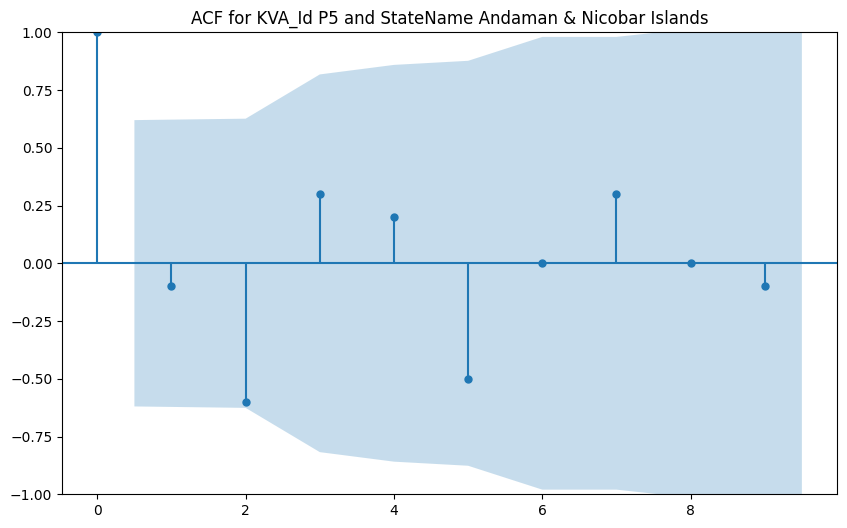

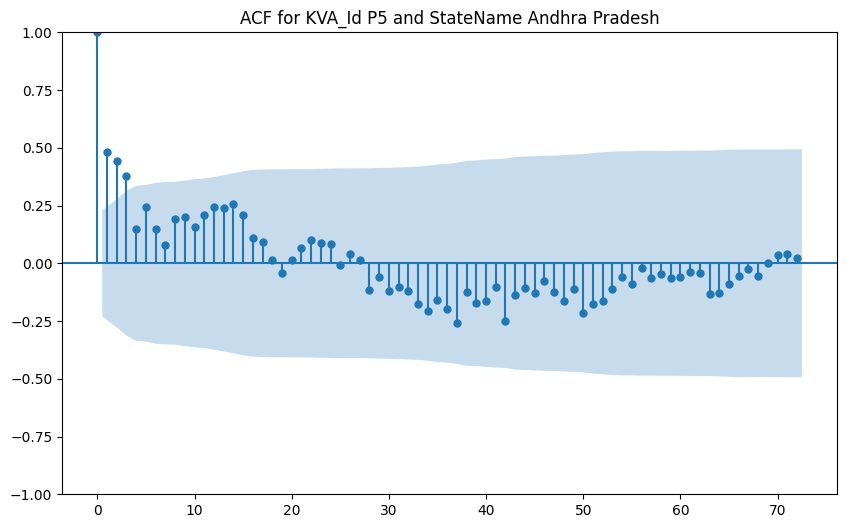

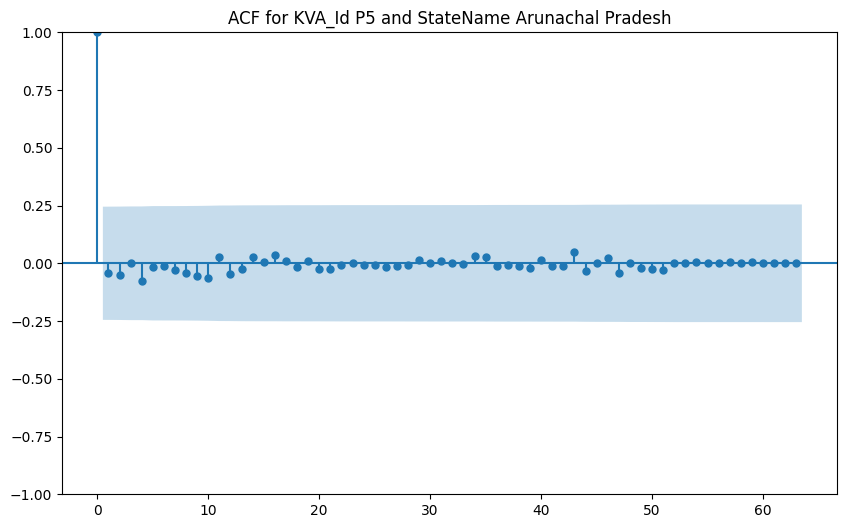

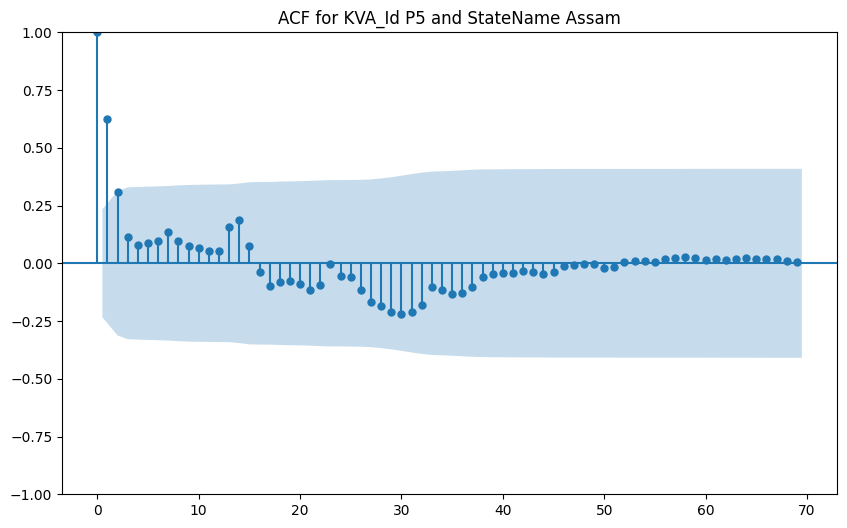

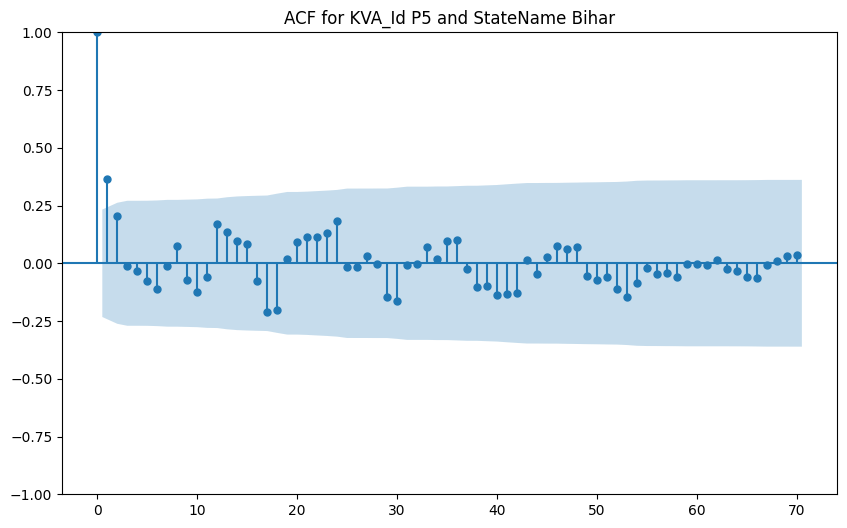

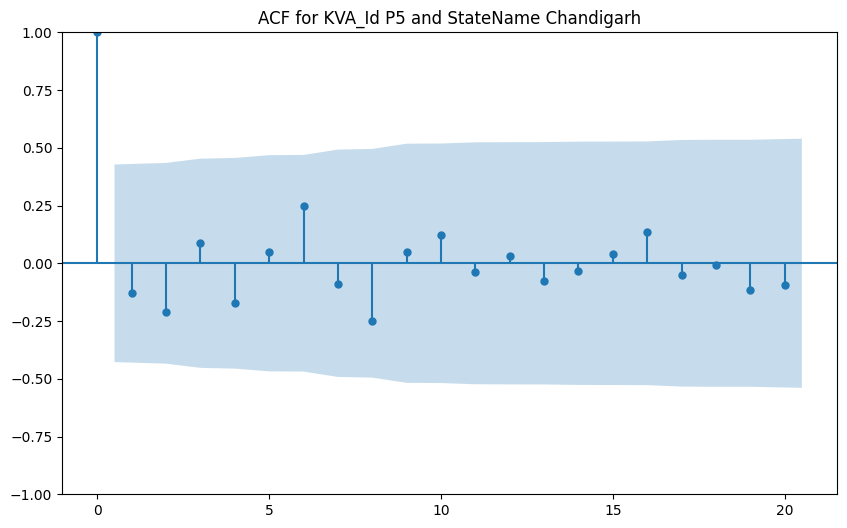

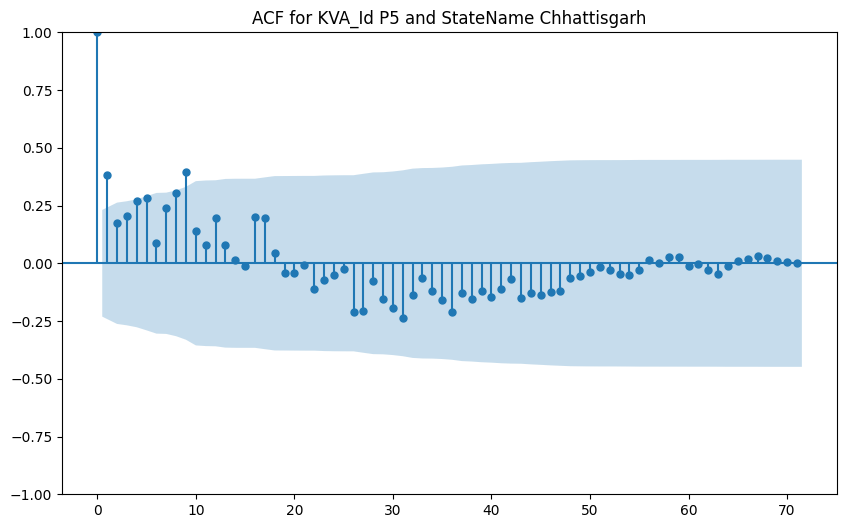

c:\Users\Tanay Yeole\Documents\My_Projects\MahindraPowerol\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


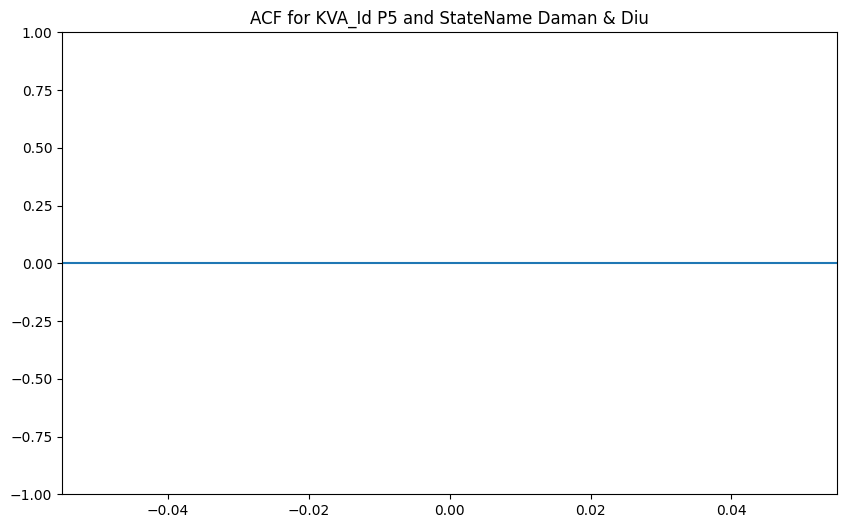

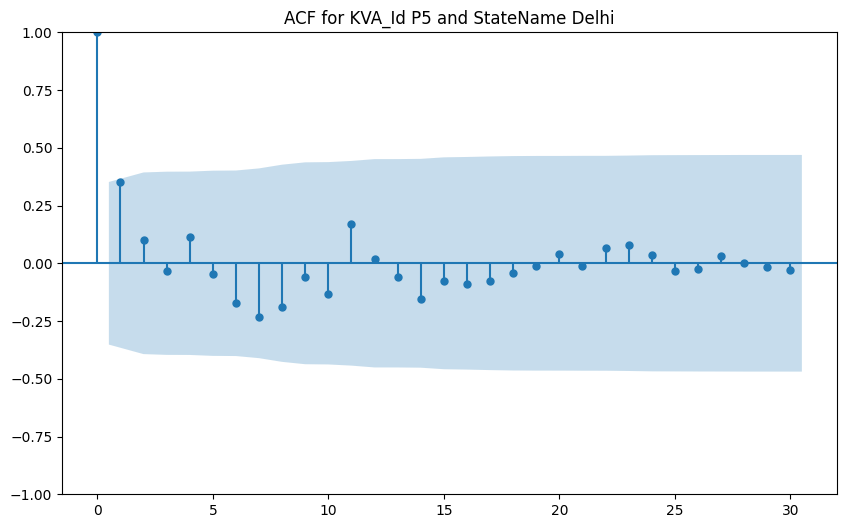

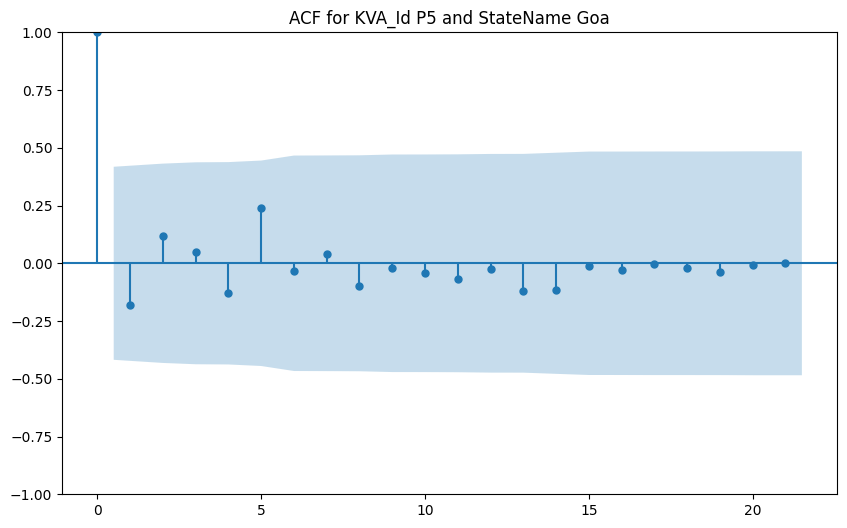

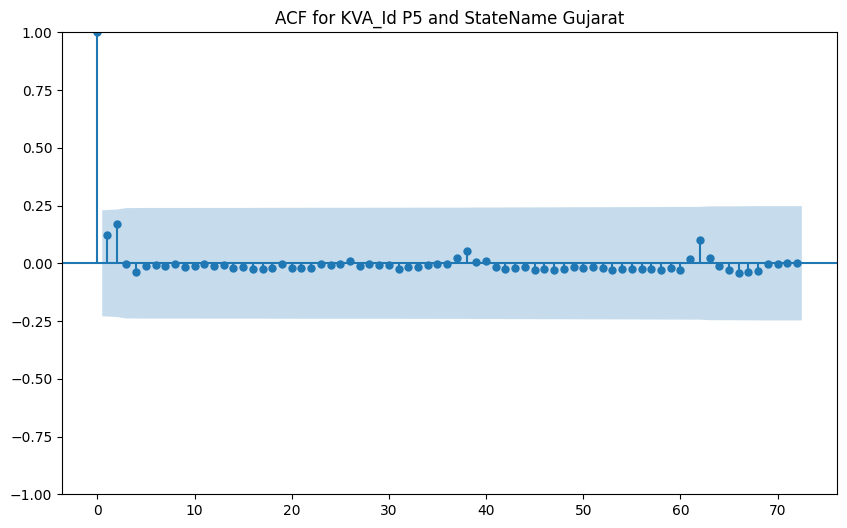

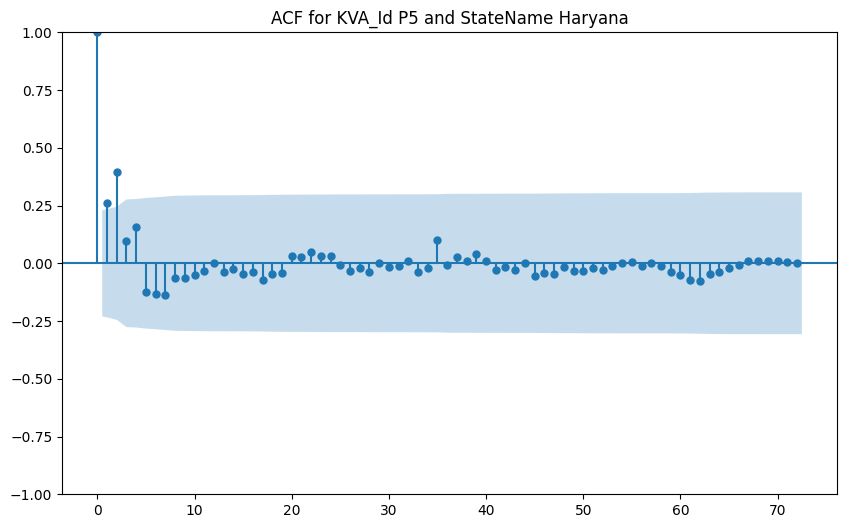

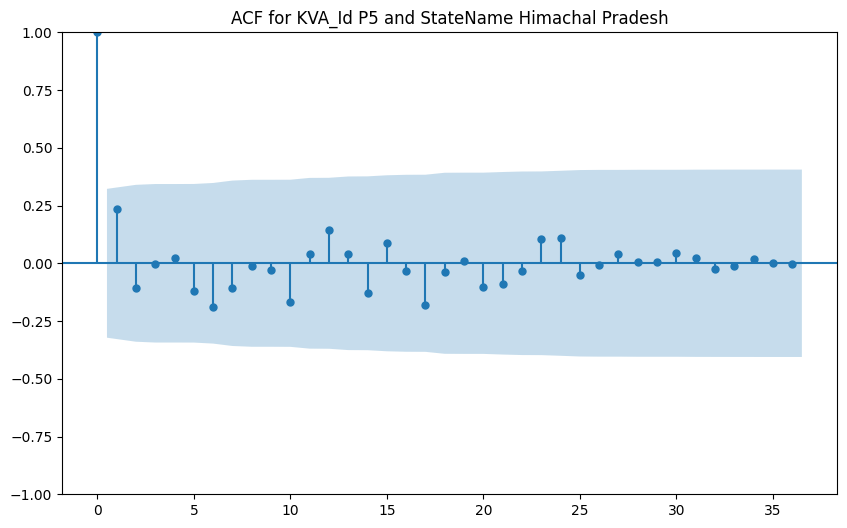

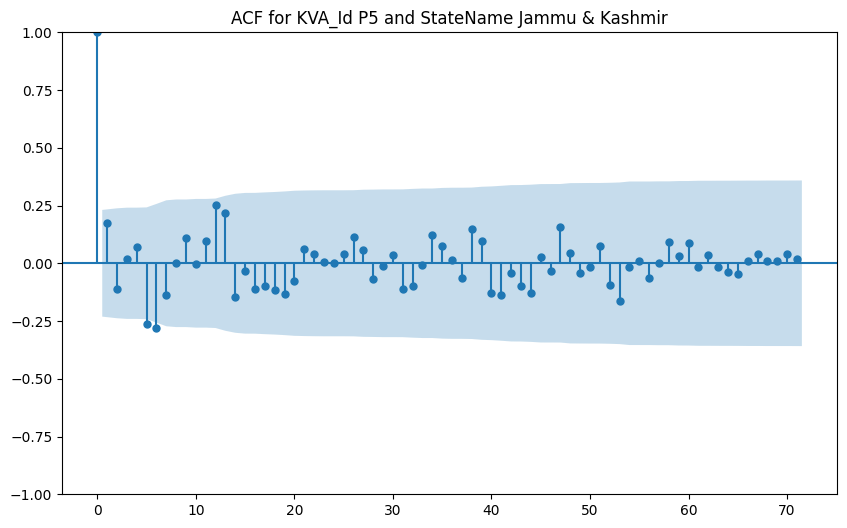

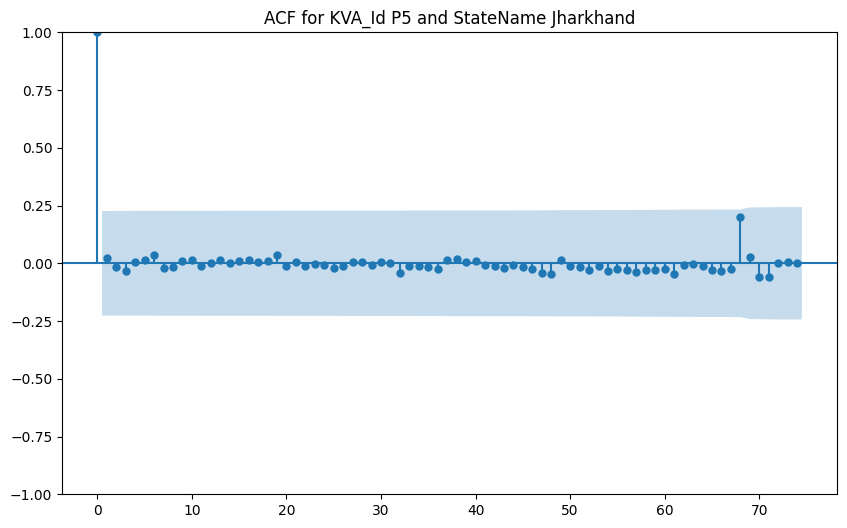

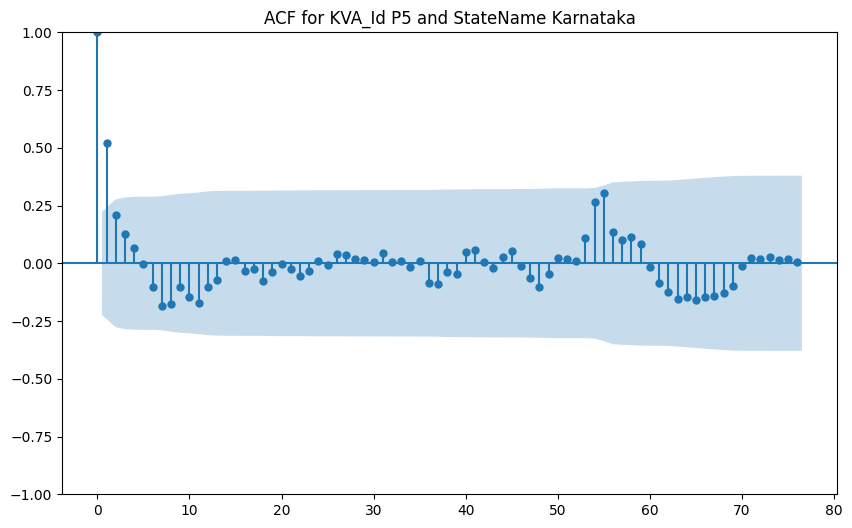

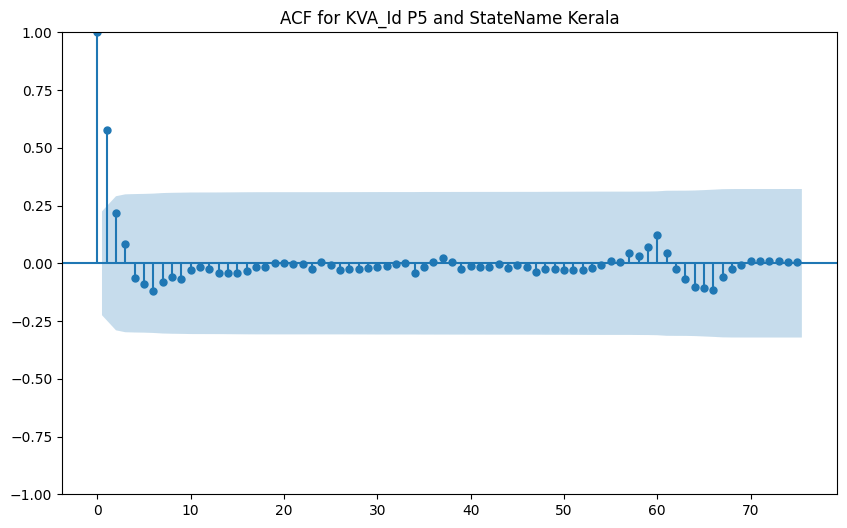

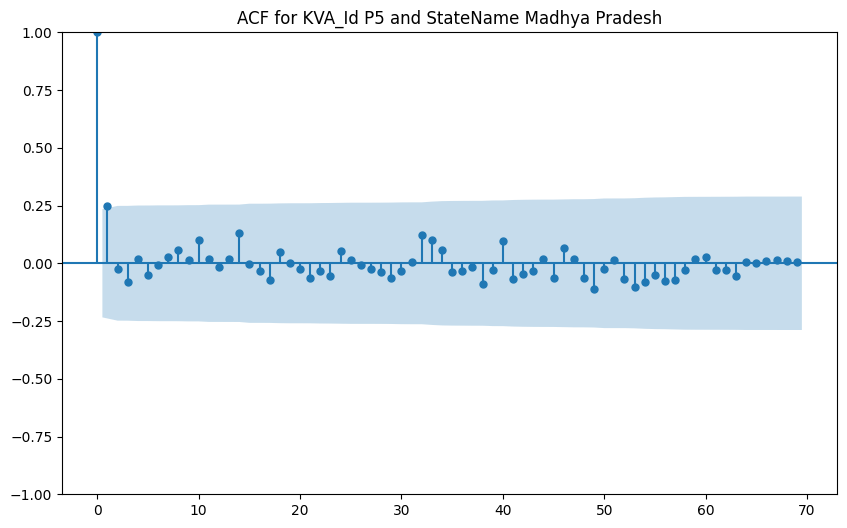

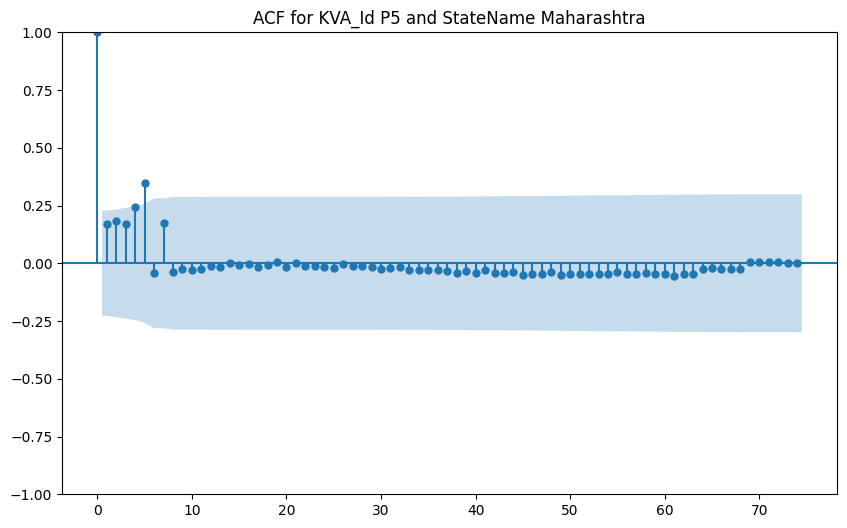

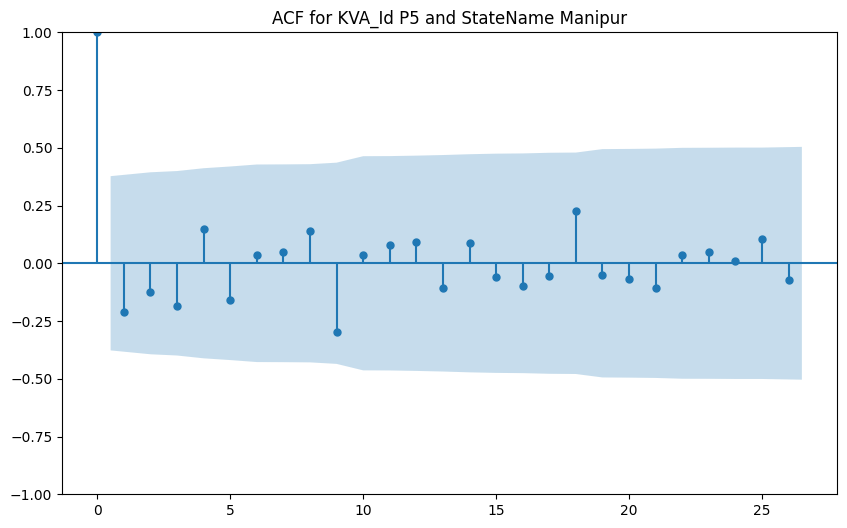

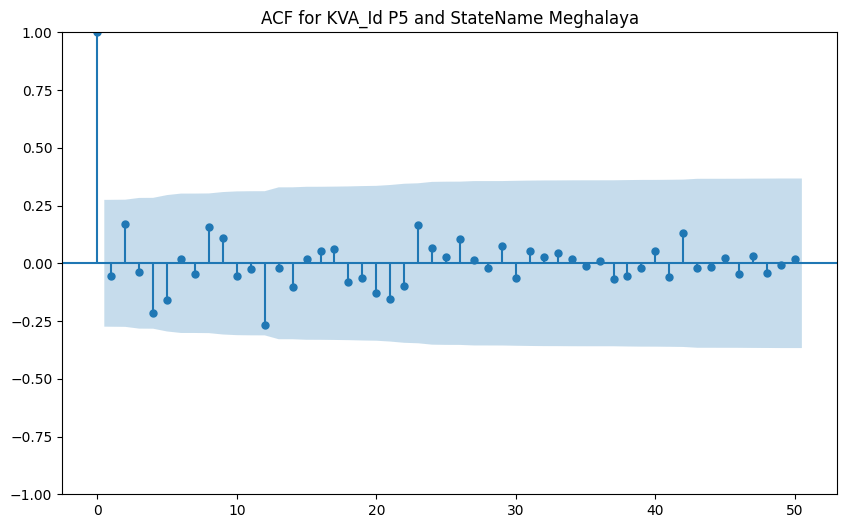

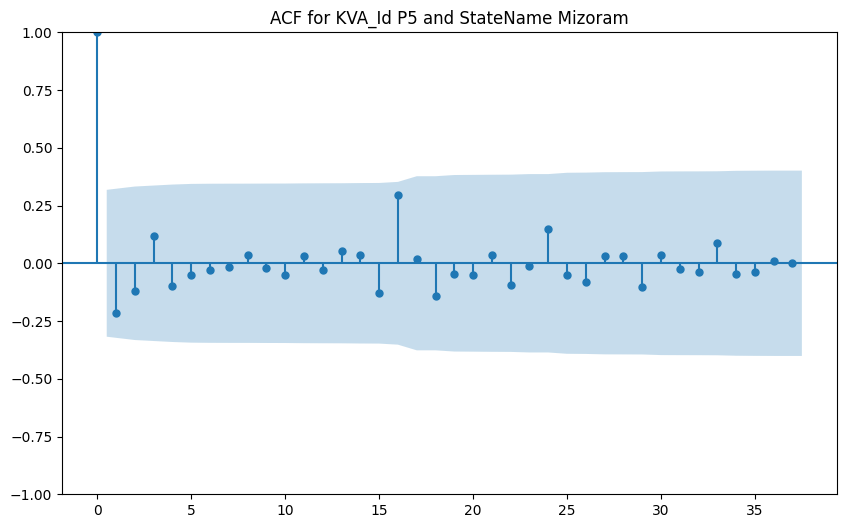

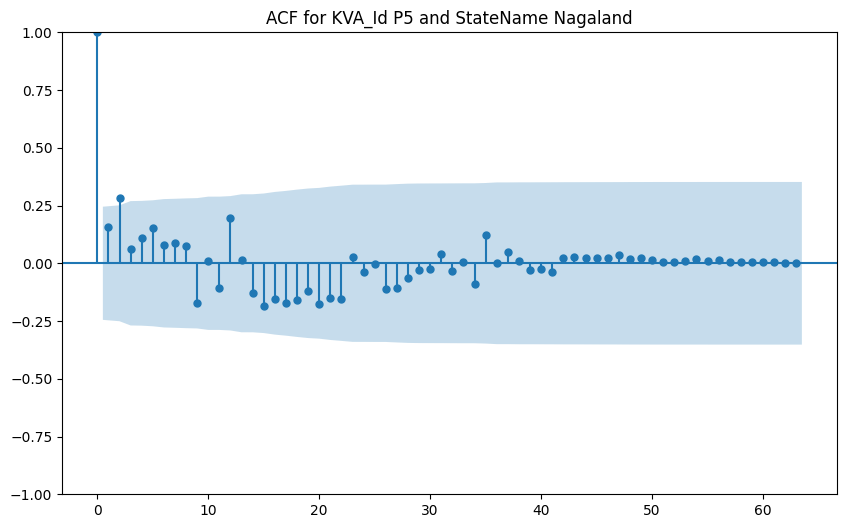

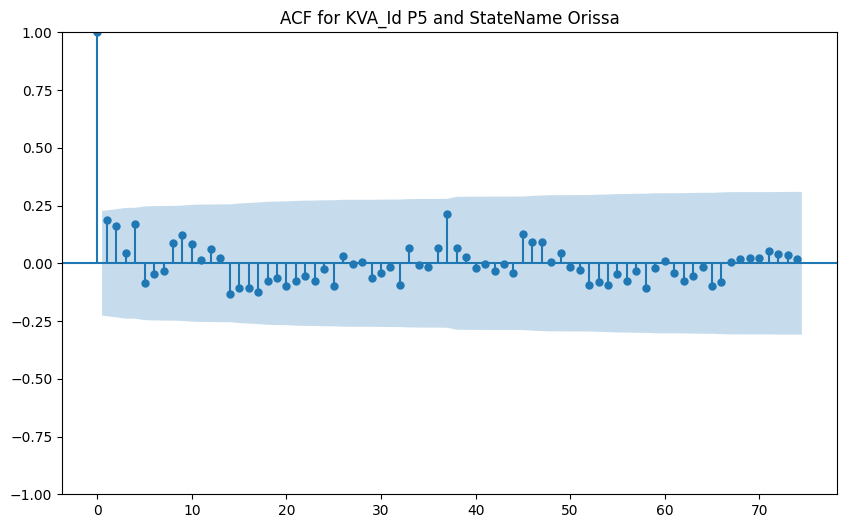

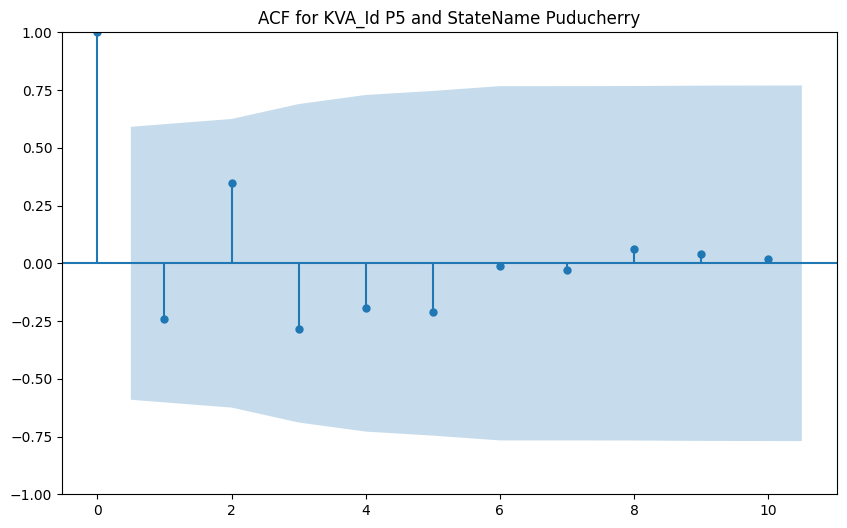

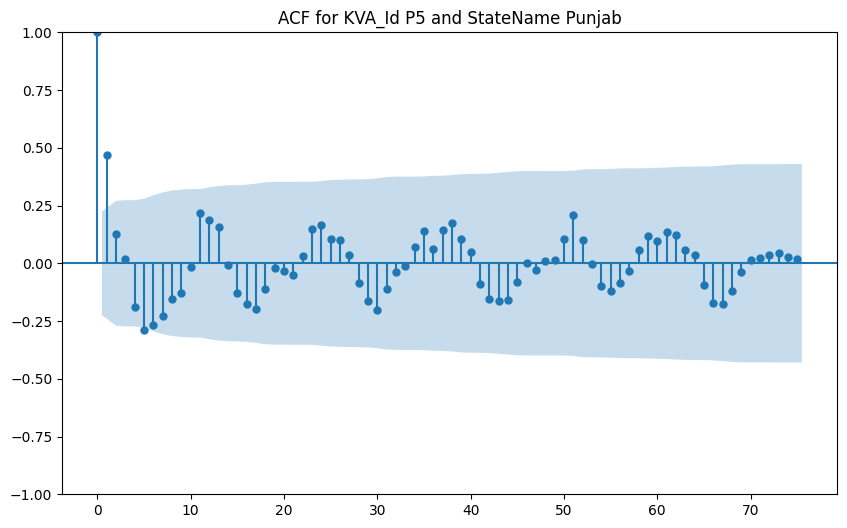

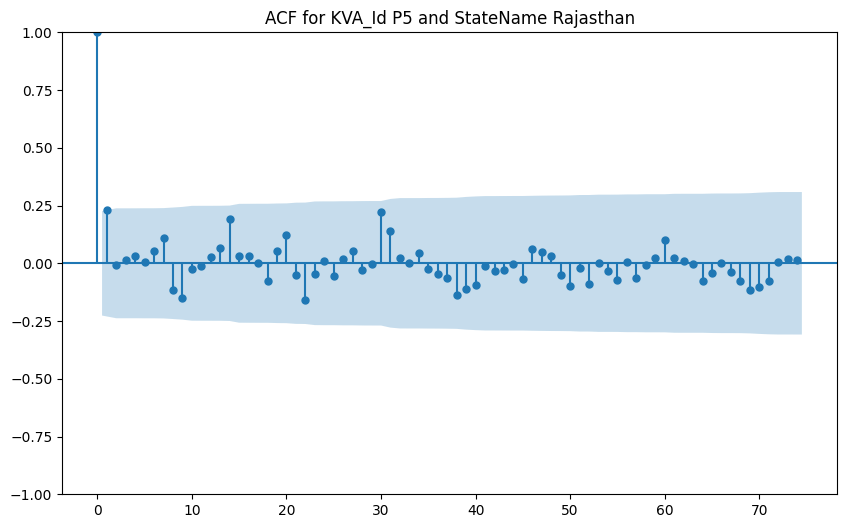

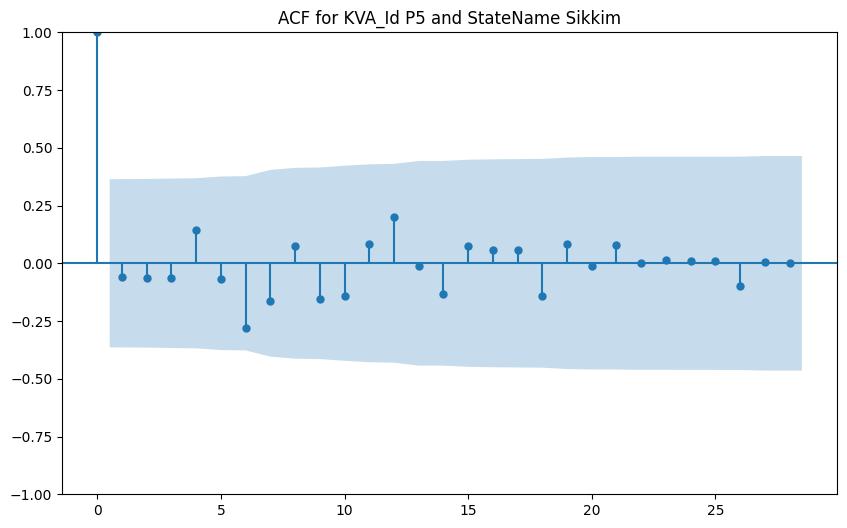

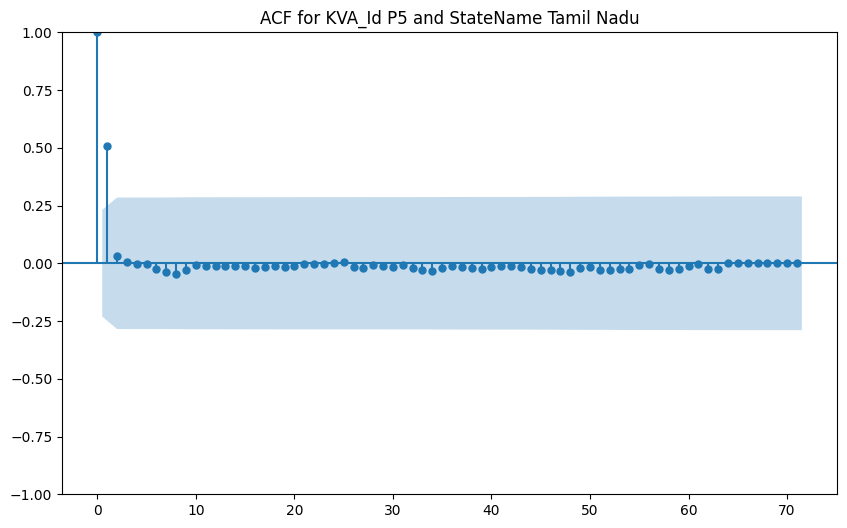

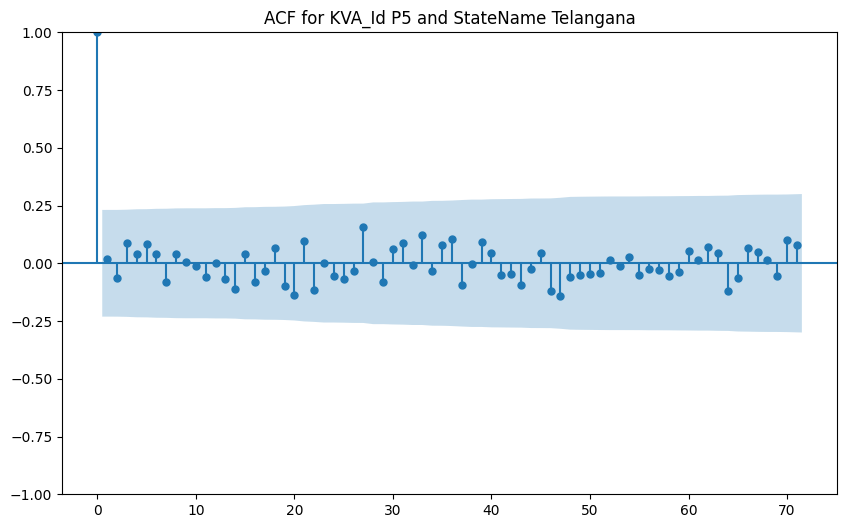

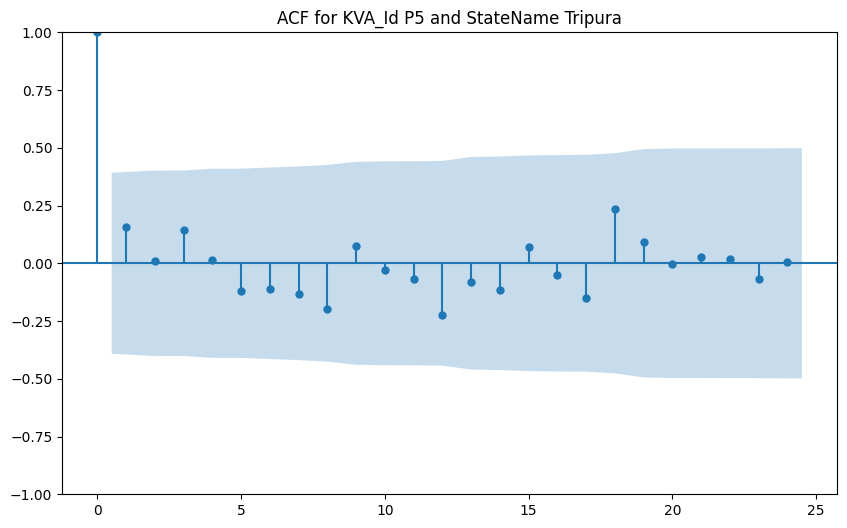

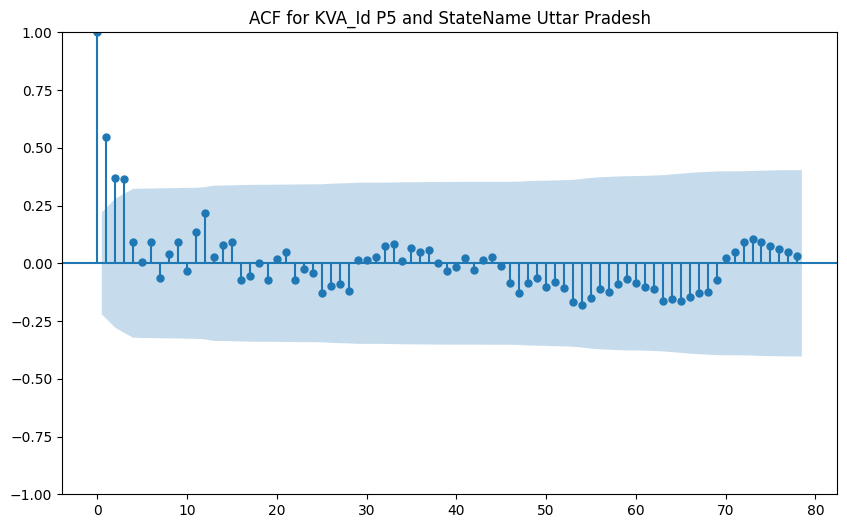

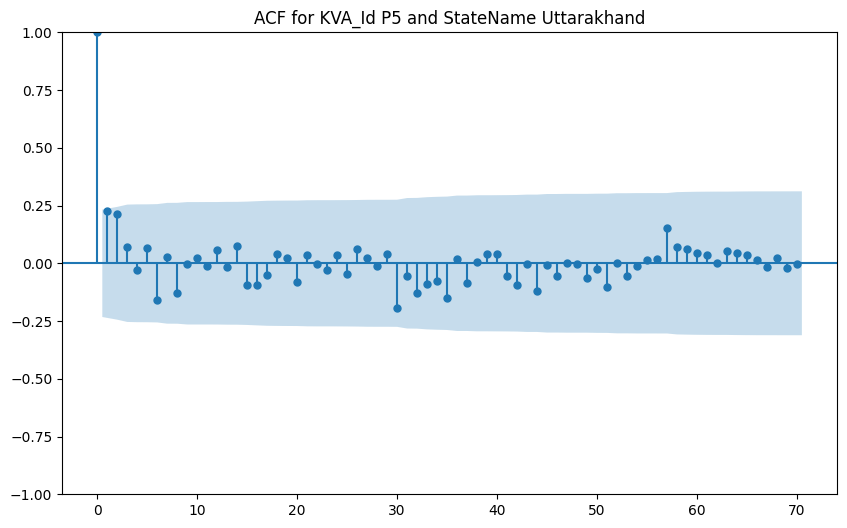

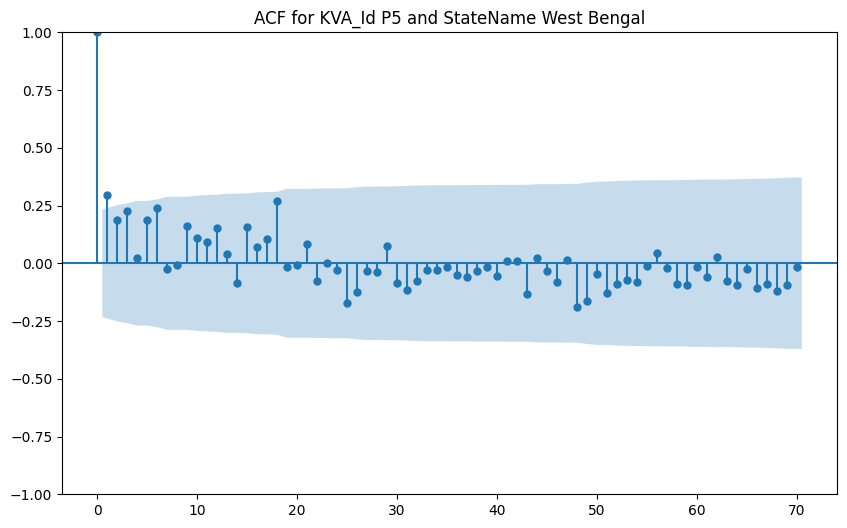

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

# Loop through each unique combination of KVA_Id and StateName
for kva_id, state_name in combined_df[["KVA_Id", "StateName"]].drop_duplicates().values:
    # Subset the dataframe for the specific KVA_Id and StateName
    subset = combined_df[
        (combined_df["KVA_Id"] == kva_id) & (combined_df["StateName"] == state_name)
    ]

    # Plot ACF for 'Enquiry_Quantity'
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_acf(subset["Enquiry_Quantity"], lags=len(subset) - 1, ax=ax)
    ax.set_title(f"ACF for KVA_Id {kva_id} and StateName {state_name}")
    plt.title(f"ACF for KVA_Id {kva_id} and StateName {state_name}")
    plt.show()

In [10]:
# Create lag features for Enquiry_Quantity, Booking_Quantity, and Invoice_Quantity
for col in ["Enquiry_Quantity", "Booking_Quantity", "Invoice_Quantity"]:
    for lag in lags:
        combined_df_filled[f"{col}_lag{lag}"] = combined_df_filled.groupby(
            ["KVA_Id", "StateName"]
        )[col].shift(lag)

In [19]:
def significant_lags_acf(series, alpha=0.05):
    print("Series Length", len(series))
    acf_values, confint = acf(series, nlags=len(series) - 1, alpha=alpha)
    upper_bound = confint[:, 1]
    # print("ACF_Values :", acf_values)
    # print("Upper Bound: ", upper_bound)

    significant_lags = [
        lag for lag, value in enumerate(acf_values) if abs(value) > upper_bound[lag]
    ]

    return significant_lags


subset = combined_df_filled[
    (combined_df_filled["KVA_Id"] == "P5")
    & (combined_df_filled["StateName"] == "Maharashtra")
]

lags = significant_lags_acf(subset["Enquiry_Quantity"])

print(f"Significant lags:", lags)

Series Length 74
Significant lags: []


In [337]:
subset

,YearMonth,KVA_Id,StateName,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,...,month_cos,Enquiry_Quantity_1month,Booking_Quantity_1month,Invoice_Quantity_1month,Enquiry_Quantity_2month,Booking_Quantity_2month,Invoice_Quantity_2month,Enquiry_Quantity_3month,Booking_Quantity_3month,Invoice_Quantity_3month
1243,2018-10,P5,Maharashtra,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,5.000000e-01,2.0,1.0,0.0,4.0,3.0,0.0,22.0,22.0,0.0
1244,2018-11,P5,Maharashtra,2.0,1.0,0.0,1.0,NaN,NaN,0.0,...,8.660254e-01,4.0,3.0,0.0,22.0,22.0,0.0,32.0,29.0,9.0
1245,2018-12,P5,Maharashtra,4.0,3.0,0.0,2.0,1.0,NaN,1.0,...,1.000000e+00,22.0,22.0,0.0,32.0,29.0,9.0,29.0,23.0,16.0
1246,2019-01,P5,Maharashtra,22.0,22.0,0.0,4.0,2.0,1.0,3.0,...,8.660254e-01,32.0,29.0,9.0,29.0,23.0,16.0,23.0,24.0,28.0
1247,2019-02,P5,Maharashtra,32.0,29.0,9.0,22.0,4.0,2.0,22.0,...,5.000000e-01,29.0,23.0,16.0,23.0,24.0,28.0,22.0,21.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,2024-07,P5,Maharashtra,4.0,4.0,42.0,1254.0,92.0,10.0,1258.0,...,-8.660254e-01,32.0,31.0,10.0,51.0,50.0,16.0,10.0,12.0,12.0
1313,2024-08,P5,Maharashtra,32.0,31.0,10.0,4.0,1254.0,92.0,4.0,...,-5.000000e-01,51.0,50.0,16.0,10.0,12.0,12.0,8.0,6.0,6.0
1314,2024-09,P5,Maharashtra,51.0,50.0,16.0,32.0,4.0,1254.0,31.0,...,-1.836970e-16,10.0,12.0,12.0,8.0,6.0,6.0,NaN,NaN,NaN
1315,2024-10,P5,Maharashtra,10.0,12.0,12.0,51.0,32.0,4.0,50.0,...,5.000000e-01,8.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
subset = subset[
    ["Enquiry_Quantity", "Booking_Quantity", "Invoice_Quantity", "YearMonth"]
]

In [21]:
print(subset["YearMonth"].dtype)

period[M]


In [22]:
subset.index

Index([1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254,
       1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266,
       1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278,
       1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290,
       1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302,
       1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314,
       1315, 1316],
      dtype='int64')

In [23]:
subset["YearMonth"] = subset["YearMonth"].dt.to_timestamp()

In [24]:
subset.set_index("YearMonth", inplace=True)
subset = subset.asfreq("MS")
subset.head()

,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity
YearMonth,,,
2018-10-01,1.0,0.0,0.0
2018-11-01,2.0,1.0,0.0
2018-12-01,4.0,3.0,0.0
2019-01-01,22.0,22.0,0.0
2019-02-01,32.0,29.0,9.0


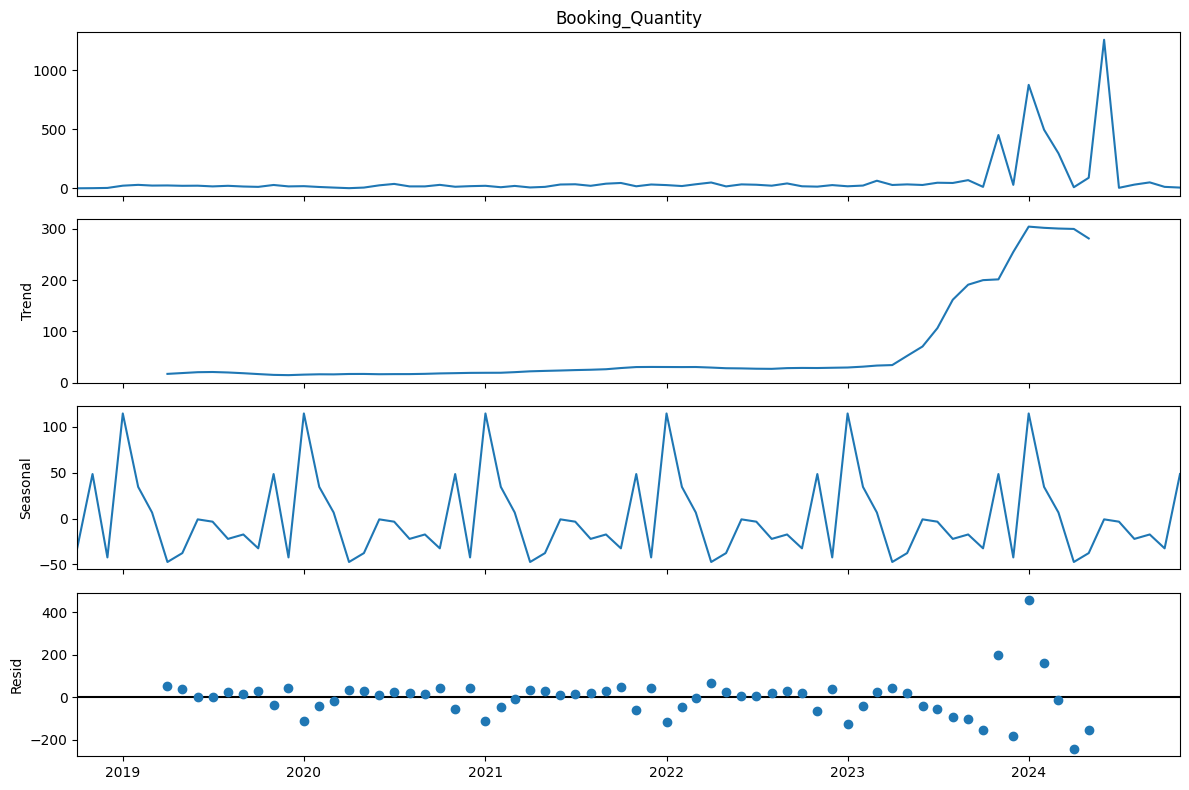

In [25]:
rcParams["figure.figsize"] = 12, 8
decomposition = sm.tsa.seasonal_decompose(subset["Booking_Quantity"], model="additive")
fig = decomposition.plot()
plt.show()

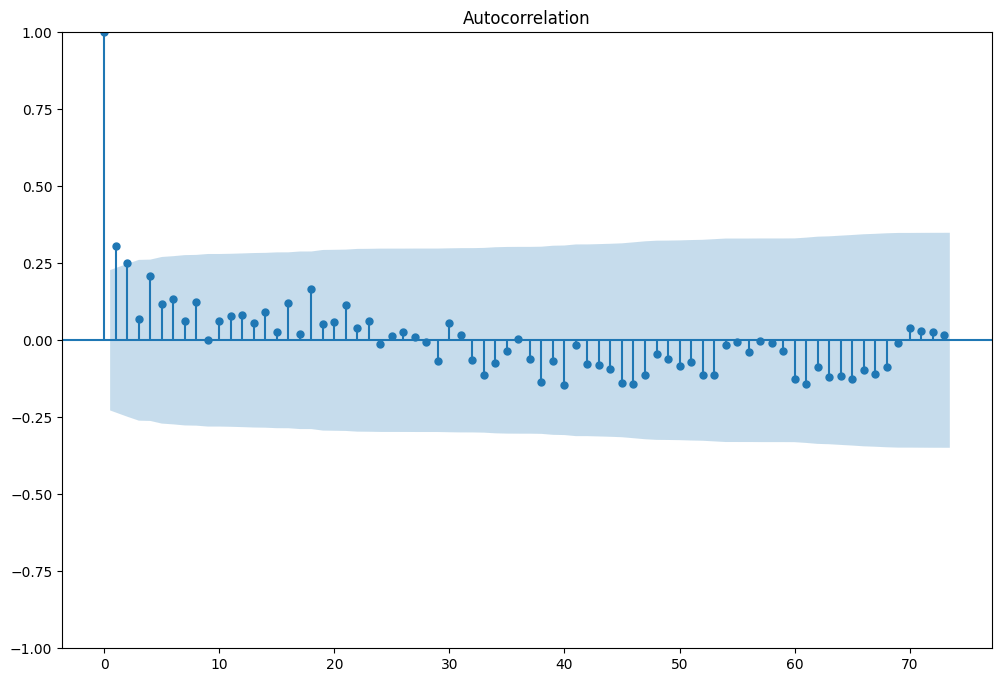

In [27]:
plot_acf(subset["Invoice_Quantity"], lags=len(subset) - 1)
plt.show()

### 2. Rolling Statistics


In [28]:
for col in ["Enquiry_Quantity", "Booking_Quantity", "Invoice_Quantity"]:
    combined_df_filled[f"{col}_rolling_mean"] = (
        combined_df_filled.groupby(["KVA_Id", "StateName"])[col]
        .rolling(rolling_window, min_periods=1)
        .mean()
        .reset_index(drop=True)
    )
    combined_df_filled[f"{col}_rolling_median"] = (
        combined_df_filled.groupby(["KVA_Id", "StateName"])[col]
        .rolling(rolling_window, min_periods=1)
        .median()
        .reset_index(drop=True)
    )
    combined_df_filled[f"{col}_rolling_std"] = (
        combined_df_filled.groupby(["KVA_Id", "StateName"])[col]
        .rolling(rolling_window, min_periods=1)
        .std()
        .reset_index(drop=True)
    )

### 3. Difference between sums


In [29]:
combined_df_filled["Enquiry_Booking_diff"] = (
    combined_df_filled["Enquiry_Quantity"] - combined_df_filled["Booking_Quantity"]
)
combined_df_filled["Booking_Invoice_diff"] = (
    combined_df_filled["Booking_Quantity"] - combined_df_filled["Invoice_Quantity"]
)

### 4. Date Features


In [30]:
combined_df_filled["month"] = combined_df_filled["YearMonth"].dt.month
combined_df_filled["month_sin"] = np.sin(2 * np.pi * combined_df_filled["month"] / 12)
combined_df_filled["month_cos"] = np.cos(2 * np.pi * combined_df_filled["month"] / 12)

### Creating Targets


In [31]:
targets = [1, 2, 3]
for target in targets:
    combined_df_filled[f"Enquiry_Quantity_{target}month"] = combined_df_filled.groupby(
        ["KVA_Id", "StateName"]
    )["Enquiry_Quantity"].shift(-target)
    combined_df_filled[f"Booking_Quantity_{target}month"] = combined_df_filled.groupby(
        ["KVA_Id", "StateName"]
    )["Booking_Quantity"].shift(-target)
    combined_df_filled[f"Invoice_Quantity_{target}month"] = combined_df_filled.groupby(
        ["KVA_Id", "StateName"]
    )["Invoice_Quantity"].shift(-target)

In [ ]:
combined_df_filled.head()

In [32]:
combined_df_filled.to_pickle(r"..\data\processed\modelling_data.pkl")

# Model Building


In [4]:
modelling_df = pd.read_pickle(r"..\data\processed\modelling_data.pkl")

In [5]:
modelling_df.head()

,YearMonth,KVA_Id,StateName,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,...,month_cos,Enquiry_Quantity_1month,Booking_Quantity_1month,Invoice_Quantity_1month,Enquiry_Quantity_2month,Booking_Quantity_2month,Invoice_Quantity_2month,Enquiry_Quantity_3month,Booking_Quantity_3month,Invoice_Quantity_3month
0,2023-03,P5,Andaman & Nicobar Islands,2.0,2.0,2.0,NaN,NaN,NaN,NaN,...,6.123234e-17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,2023-04,P5,Andaman & Nicobar Islands,0.0,0.0,0.0,2.0,NaN,NaN,2.0,...,-5.000000e-01,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2,2023-05,P5,Andaman & Nicobar Islands,0.0,0.0,0.0,0.0,2.0,NaN,0.0,...,-8.660254e-01,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,2023-06,P5,Andaman & Nicobar Islands,1.0,1.0,1.0,0.0,0.0,2.0,0.0,...,-1.000000e+00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,2023-07,P5,Andaman & Nicobar Islands,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-8.660254e-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
modelling_mh = modelling_df[modelling_df["StateName"] == "Maharashtra"]

In [7]:
modelling_mh

,YearMonth,KVA_Id,StateName,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,...,month_cos,Enquiry_Quantity_1month,Booking_Quantity_1month,Invoice_Quantity_1month,Enquiry_Quantity_2month,Booking_Quantity_2month,Invoice_Quantity_2month,Enquiry_Quantity_3month,Booking_Quantity_3month,Invoice_Quantity_3month
1243,2018-10,P5,Maharashtra,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,5.000000e-01,2.0,1.0,0.0,4.0,3.0,0.0,22.0,22.0,0.0
1244,2018-11,P5,Maharashtra,2.0,1.0,0.0,1.0,NaN,NaN,0.0,...,8.660254e-01,4.0,3.0,0.0,22.0,22.0,0.0,32.0,29.0,9.0
1245,2018-12,P5,Maharashtra,4.0,3.0,0.0,2.0,1.0,NaN,1.0,...,1.000000e+00,22.0,22.0,0.0,32.0,29.0,9.0,29.0,23.0,16.0
1246,2019-01,P5,Maharashtra,22.0,22.0,0.0,4.0,2.0,1.0,3.0,...,8.660254e-01,32.0,29.0,9.0,29.0,23.0,16.0,23.0,24.0,28.0
1247,2019-02,P5,Maharashtra,32.0,29.0,9.0,22.0,4.0,2.0,22.0,...,5.000000e-01,29.0,23.0,16.0,23.0,24.0,28.0,22.0,21.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,2024-07,P5,Maharashtra,4.0,4.0,42.0,1254.0,92.0,10.0,1258.0,...,-8.660254e-01,32.0,31.0,10.0,51.0,50.0,16.0,10.0,12.0,12.0
1313,2024-08,P5,Maharashtra,32.0,31.0,10.0,4.0,1254.0,92.0,4.0,...,-5.000000e-01,51.0,50.0,16.0,10.0,12.0,12.0,8.0,6.0,6.0
1314,2024-09,P5,Maharashtra,51.0,50.0,16.0,32.0,4.0,1254.0,31.0,...,-1.836970e-16,10.0,12.0,12.0,8.0,6.0,6.0,NaN,NaN,NaN
1315,2024-10,P5,Maharashtra,10.0,12.0,12.0,51.0,32.0,4.0,50.0,...,5.000000e-01,8.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
pred_horizon = 3
target_columns = (
    [f"Enquiry_Quantity_{horizon}month" for horizon in range(1, pred_horizon + 1)]
    + [f"Booking_Quantity_{horizon}month" for horizon in range(1, pred_horizon + 1)]
    + [f"Invoice_Quantity_{horizon}month" for horizon in range(1, pred_horizon + 1)]
)

In [9]:
target_columns

['Enquiry_Quantity_1month',
 'Enquiry_Quantity_2month',
 'Enquiry_Quantity_3month',
 'Booking_Quantity_1month',
 'Booking_Quantity_2month',
 'Booking_Quantity_3month',
 'Invoice_Quantity_1month',
 'Invoice_Quantity_2month',
 'Invoice_Quantity_3month']

In [10]:
first_test_date = pd.Period(dt.datetime.strptime("2024-09", "%Y-%m"), freq="M")
end_test_date = pd.Period(dt.datetime.strptime("2024-11", "%Y-%m"), freq="M")

In [11]:
modelling_mh_copy = modelling_mh.copy()

In [12]:
modelling_mh_copy.set_index("YearMonth", inplace=True)
# modelling_mh_copy["lag_feature_nan"] = modelling_mh_copy["lag_feature"].isnull().astype(int)
null_cols = [
    "Enquiry_Quantity_lag1",
    "Enquiry_Quantity_lag2",
    "Enquiry_Quantity_lag3",
    "Booking_Quantity_lag1",
    "Booking_Quantity_lag2",
    "Booking_Quantity_lag3",
    "Invoice_Quantity_lag1",
    "Invoice_Quantity_lag2",
    "Invoice_Quantity_lag3",
    "Enquiry_Quantity_rolling_mean",
    "Enquiry_Quantity_rolling_median",
    "Enquiry_Quantity_rolling_std",
    "Booking_Quantity_rolling_mean",
    "Booking_Quantity_rolling_median",
    "Booking_Quantity_rolling_std",
    "Invoice_Quantity_rolling_mean",
    "Invoice_Quantity_rolling_median",
    "Invoice_Quantity_rolling_std",
    "Enquiry_Booking_diff",
    "Booking_Invoice_diff",
    "month",
    "month_sin",
    "month_cos",
    "Enquiry_Quantity_1month",
    "Booking_Quantity_1month",
    "Invoice_Quantity_1month",
    "Enquiry_Quantity_2month",
    "Booking_Quantity_2month",
    "Invoice_Quantity_2month",
    "Enquiry_Quantity_3month",
    "Booking_Quantity_3month",
    "Invoice_Quantity_3month",
]
modelling_mh_copy[null_cols] = modelling_mh_copy[null_cols].fillna(
    modelling_mh_copy[null_cols].mean()
)  # Or any other method

In [13]:
biggest_products = modelling_mh_copy.copy()
biggest_products = biggest_products.groupby(["StateName", "KVA_Id"])[
    ["Enquiry_Quantity"]
].sum()
biggest_products.sort_values(by=["Enquiry_Quantity"], ascending=False, inplace=True)
biggest_products.reset_index(inplace=True)
biggest_products

,StateName,KVA_Id,Enquiry_Quantity
0,Maharashtra,P5,5043.0


In [14]:
biggest_products.shape[0]

1

|---------------------------------	Enquiry_Quantity_1month	---------------------------------|
------------------------ Preparing Train Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Booking_Quantity_rolling_median,Booking_Quantity_rolling_std,Invoice_Quantity_rolling_mean,Invoice_Quantity_rolling_median,Invoice_Quantity_rolling_std,Enquiry_Booking_diff,Booking_Invoice_diff,month,month_sin,month_cos
YearMonth,,,,,,,,,,,,,,,,,,,,,
2018-10,1.0,0.0,0.0,68.972603,69.791667,70.056338,68.958904,69.75,70.028169,17.424658,...,0.0,65.184974,0.0,0.0,7.780861,1.0,0.0,10,-8.660254e-01,0.500000
2018-11,2.0,1.0,0.0,1.000000,69.791667,70.056338,0.000000,69.75,70.028169,0.000000,...,0.5,0.707107,0.0,0.0,0.000000,1.0,1.0,11,-5.000000e-01,0.866025
2018-12,4.0,3.0,0.0,2.000000,1.000000,70.056338,1.000000,0.00,70.028169,0.000000,...,1.0,1.527525,0.0,0.0,0.000000,1.0,3.0,12,-2.449294e-16,1.000000
2019-01,22.0,22.0,0.0,4.000000,2.000000,1.000000,3.000000,1.00,0.000000,0.000000,...,3.0,11.590226,0.0,0.0,0.000000,0.0,22.0,1,5.000000e-01,0.866025
2019-02,32.0,29.0,9.0,22.000000,4.000000,2.000000,22.000000,3.00,1.000000,0.000000,...,22.0,13.453624,3.0,0.0,5.196152,3.0,20.0,2,8.660254e-01,0.500000


YearMonth
2018-10     2.0
2018-11     4.0
2018-12    22.0
2019-01    32.0
2019-02    29.0
Freq: M, Name: Enquiry_Quantity_1month, dtype: float64

------------------------ Preparing Test Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Booking_Quantity_rolling_median,Booking_Quantity_rolling_std,Invoice_Quantity_rolling_mean,Invoice_Quantity_rolling_median,Invoice_Quantity_rolling_std,Enquiry_Booking_diff,Booking_Invoice_diff,month,month_sin,month_cos
YearMonth,,,,,,,,,,,,,,,,,,,,,
2024-09,51.0,50.0,16.0,32.0,4.0,1254.0,31.0,4.0,1258.0,10.0,...,31.0,23.115651,22.666667,16.0,17.009801,1.0,34.0,9,-1.000000,-1.836970e-16
2024-10,10.0,12.0,12.0,51.0,32.0,4.0,50.0,31.0,4.0,16.0,...,31.0,19.000000,12.666667,12.0,3.055050,-2.0,0.0,10,-0.866025,5.000000e-01
2024-11,8.0,6.0,6.0,10.0,51.0,32.0,12.0,50.0,31.0,12.0,...,12.0,23.860707,11.333333,12.0,5.033223,2.0,0.0,11,-0.500000,8.660254e-01


YearMonth
2024-09    10.000000
2024-10     8.000000
2024-11    69.068493
Freq: M, Name: Enquiry_Quantity_1month, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
RandomForestRegressor(max_depth=5, min_samples_leaf=7, n_jobs=3,
                      random_state=123)

The best score: 
-48598.201459555174

The best parameters: 
{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 7, 'n_estimators': 100}


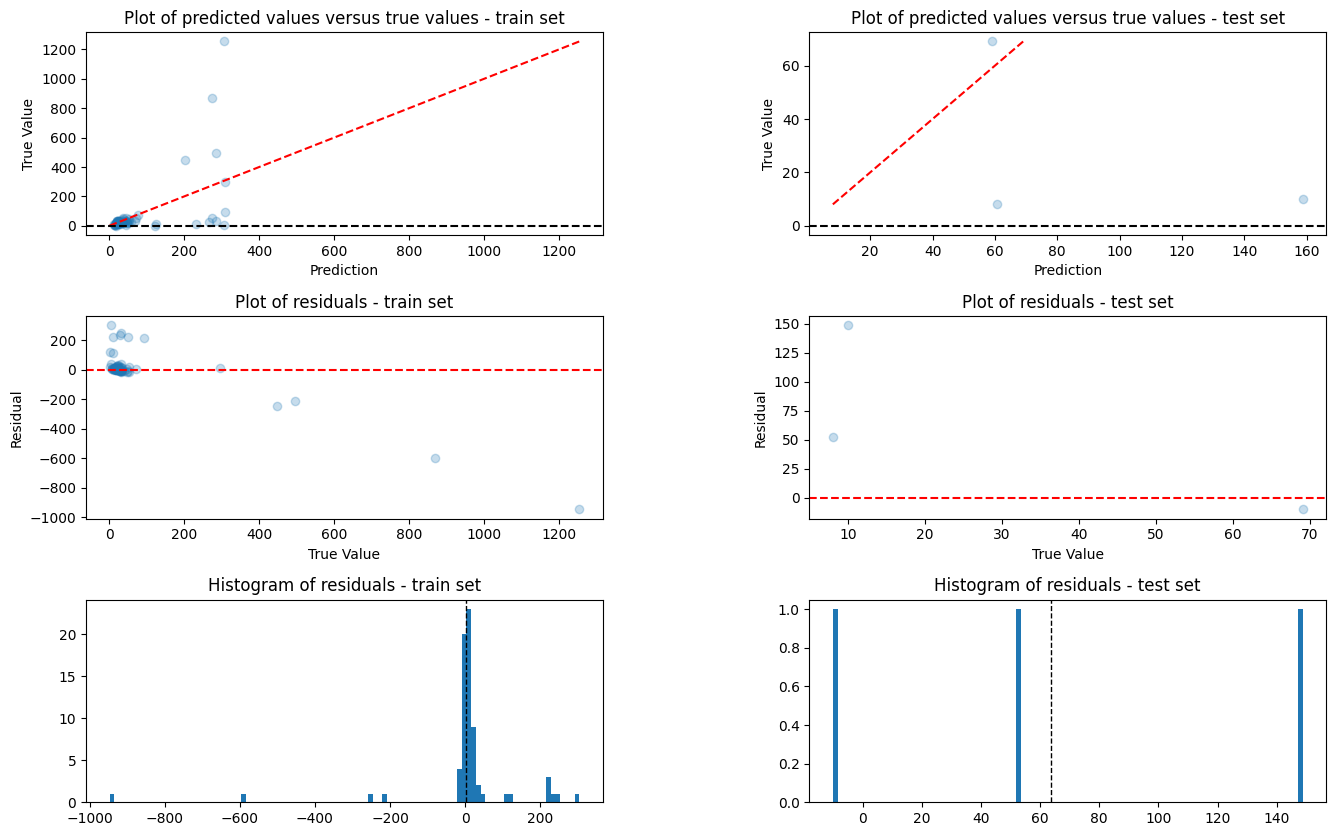

RMSE train: 157.19058025762746
DPA  train: 14.184594265581453
BIAS train: 1.8867710117969634

RMSE test:  91.26905510786177
DPA  test: -142.78920849130685
BIAS test: 219.72304598349268


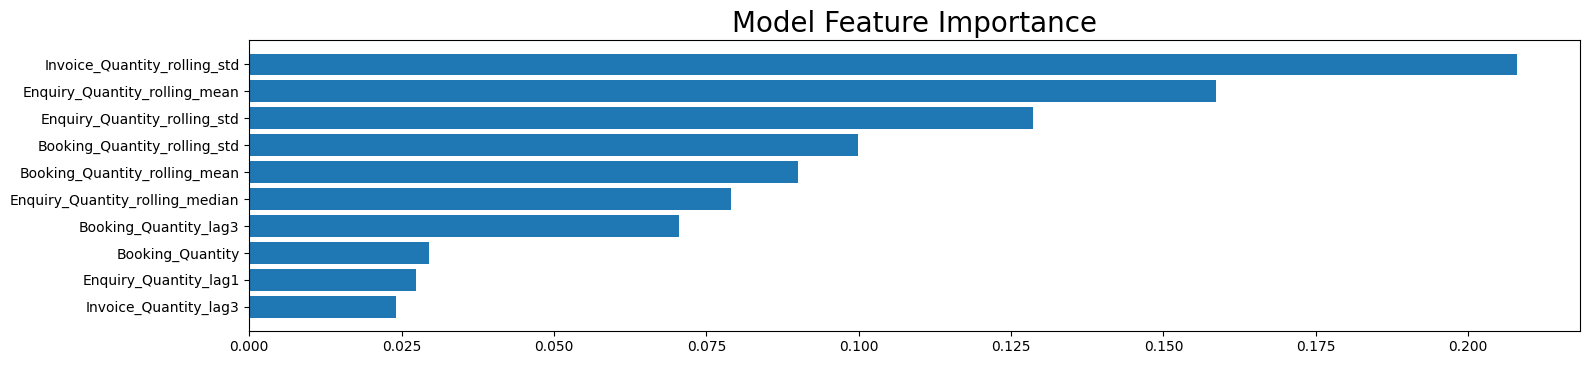

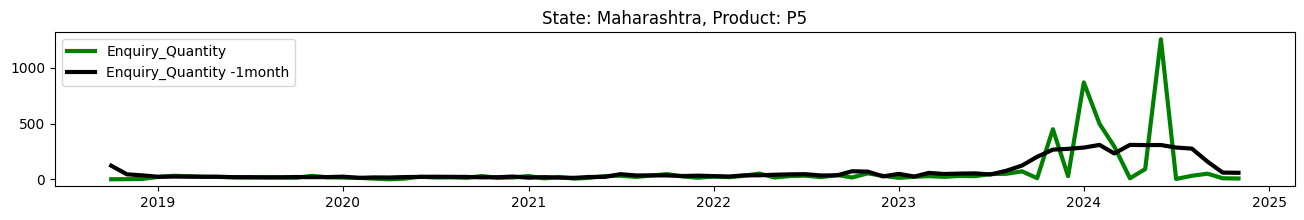

|---------------------------------	Enquiry_Quantity_2month	---------------------------------|
------------------------ Preparing Train Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Booking_Quantity_rolling_std,Invoice_Quantity_rolling_mean,Invoice_Quantity_rolling_median,Invoice_Quantity_rolling_std,Enquiry_Booking_diff,Booking_Invoice_diff,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2018-10,1.0,0.0,0.0,68.972603,69.791667,70.056338,68.958904,69.75,70.028169,17.424658,...,65.184974,0.0,0.0,7.780861,1.0,0.0,10,-8.660254e-01,0.500000,122.678902
2018-11,2.0,1.0,0.0,1.000000,69.791667,70.056338,0.000000,69.75,70.028169,0.000000,...,0.707107,0.0,0.0,0.000000,1.0,1.0,11,-5.000000e-01,0.866025,45.502011
2018-12,4.0,3.0,0.0,2.000000,1.000000,70.056338,1.000000,0.00,70.028169,0.000000,...,1.527525,0.0,0.0,0.000000,1.0,3.0,12,-2.449294e-16,1.000000,36.147382
2019-01,22.0,22.0,0.0,4.000000,2.000000,1.000000,3.000000,1.00,0.000000,0.000000,...,11.590226,0.0,0.0,0.000000,0.0,22.0,1,5.000000e-01,0.866025,23.584870
2019-02,32.0,29.0,9.0,22.000000,4.000000,2.000000,22.000000,3.00,1.000000,0.000000,...,13.453624,3.0,0.0,5.196152,3.0,20.0,2,8.660254e-01,0.500000,25.159711


YearMonth
2018-10     4.0
2018-11    22.0
2018-12    32.0
2019-01    29.0
2019-02    23.0
Freq: M, Name: Enquiry_Quantity_2month, dtype: float64

------------------------ Preparing Test Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Booking_Quantity_rolling_std,Invoice_Quantity_rolling_mean,Invoice_Quantity_rolling_median,Invoice_Quantity_rolling_std,Enquiry_Booking_diff,Booking_Invoice_diff,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2024-09,51.0,50.0,16.0,32.0,4.0,1254.0,31.0,4.0,1258.0,10.0,...,23.115651,22.666667,16.0,17.009801,1.0,34.0,9,-1.000000,-1.836970e-16,158.728333
2024-10,10.0,12.0,12.0,51.0,32.0,4.0,50.0,31.0,4.0,16.0,...,19.000000,12.666667,12.0,3.055050,-2.0,0.0,10,-0.866025,5.000000e-01,60.622892
2024-11,8.0,6.0,6.0,10.0,51.0,32.0,12.0,50.0,31.0,12.0,...,23.860707,11.333333,12.0,5.033223,2.0,0.0,11,-0.500000,8.660254e-01,59.026813


YearMonth
2024-09     8.0
2024-10    70.0
2024-11    70.0
Freq: M, Name: Enquiry_Quantity_2month, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
RandomForestRegressor(max_depth=15, min_samples_leaf=3, n_jobs=3,
                      random_state=123)

The best score: 
-42006.07483617359

The best parameters: 
{'criterion': 'squared_error', 'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 100}


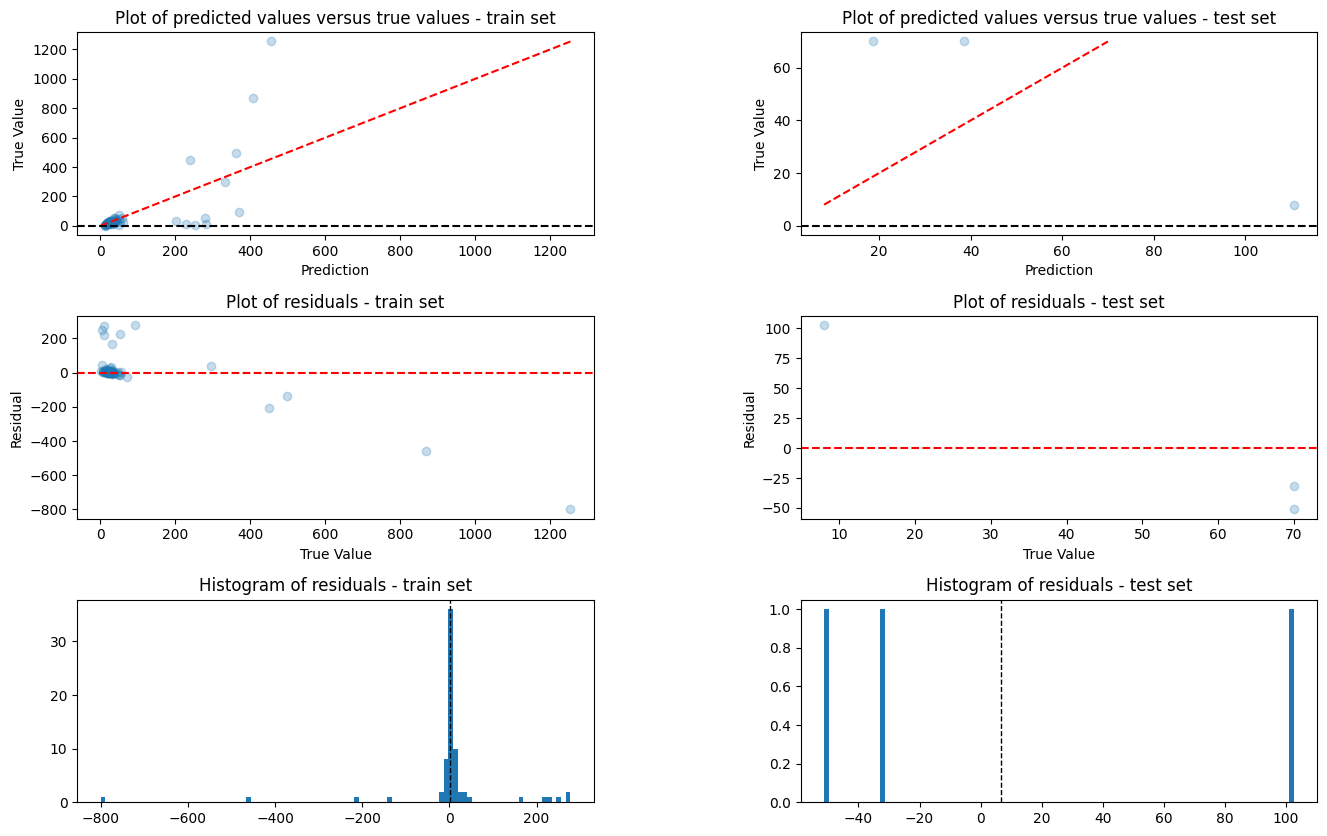

RMSE train: 133.37820727605916
DPA  train: 30.353030101743343
BIAS train: 2.1412375796566896

RMSE test:  68.65710934400282
DPA  test: -25.192018154518152
BIAS test: 13.454376779376762


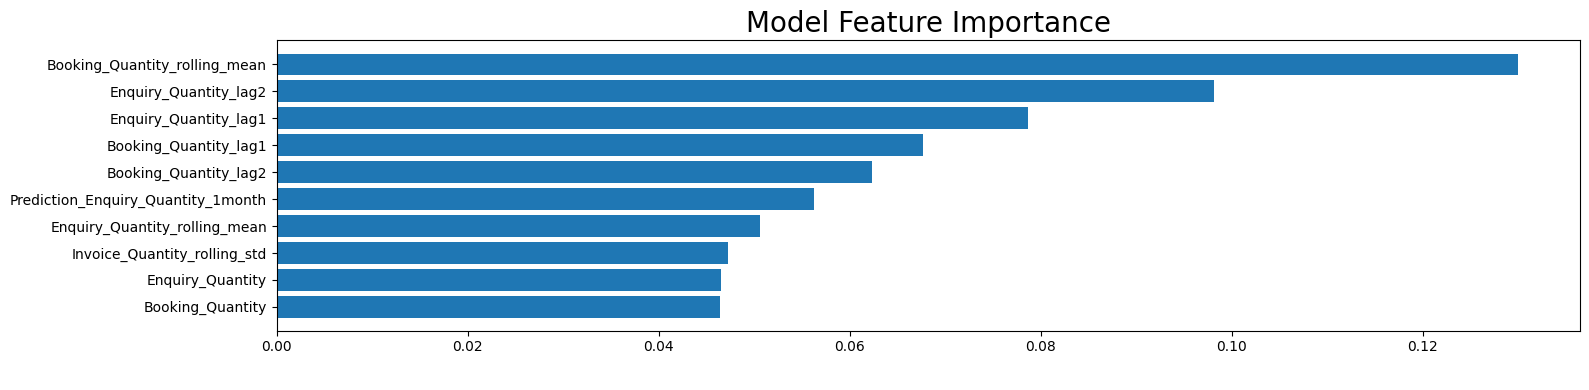

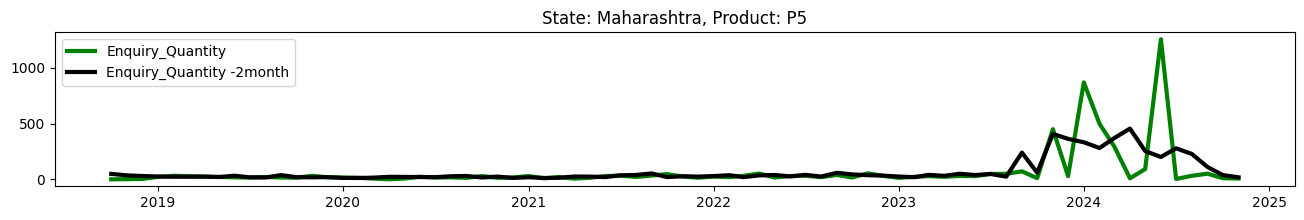

|---------------------------------	Enquiry_Quantity_3month	---------------------------------|
------------------------ Preparing Train Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Invoice_Quantity_rolling_mean,Invoice_Quantity_rolling_median,Invoice_Quantity_rolling_std,Enquiry_Booking_diff,Booking_Invoice_diff,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2018-10,1.0,0.0,0.0,68.972603,69.791667,70.056338,68.958904,69.75,70.028169,17.424658,...,0.0,0.0,7.780861,1.0,0.0,10,-8.660254e-01,0.500000,122.678902,49.314860
2018-11,2.0,1.0,0.0,1.000000,69.791667,70.056338,0.000000,69.75,70.028169,0.000000,...,0.0,0.0,0.000000,1.0,1.0,11,-5.000000e-01,0.866025,45.502011,35.883036
2018-12,4.0,3.0,0.0,2.000000,1.000000,70.056338,1.000000,0.00,70.028169,0.000000,...,0.0,0.0,0.000000,1.0,3.0,12,-2.449294e-16,1.000000,36.147382,30.620872
2019-01,22.0,22.0,0.0,4.000000,2.000000,1.000000,3.000000,1.00,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,22.0,1,5.000000e-01,0.866025,23.584870,25.822887
2019-02,32.0,29.0,9.0,22.000000,4.000000,2.000000,22.000000,3.00,1.000000,0.000000,...,3.0,0.0,5.196152,3.0,20.0,2,8.660254e-01,0.500000,25.159711,23.805435


YearMonth
2018-10    22.0
2018-11    32.0
2018-12    29.0
2019-01    23.0
2019-02    22.0
Freq: M, Name: Enquiry_Quantity_3month, dtype: float64

------------------------ Preparing Test Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Invoice_Quantity_rolling_mean,Invoice_Quantity_rolling_median,Invoice_Quantity_rolling_std,Enquiry_Booking_diff,Booking_Invoice_diff,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2024-09,51.0,50.0,16.0,32.0,4.0,1254.0,31.0,4.0,1258.0,10.0,...,22.666667,16.0,17.009801,1.0,34.0,9,-1.000000,-1.836970e-16,158.728333,110.598332
2024-10,10.0,12.0,12.0,51.0,32.0,4.0,50.0,31.0,4.0,16.0,...,12.666667,12.0,3.055050,-2.0,0.0,10,-0.866025,5.000000e-01,60.622892,38.569260
2024-11,8.0,6.0,6.0,10.0,51.0,32.0,12.0,50.0,31.0,12.0,...,11.333333,12.0,5.033223,2.0,0.0,11,-0.500000,8.660254e-01,59.026813,18.744885


YearMonth
2024-09    70.929577
2024-10    70.929577
2024-11    70.929577
Freq: M, Name: Enquiry_Quantity_3month, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
RandomForestRegressor(max_depth=5, min_samples_leaf=3, n_jobs=3,
                      random_state=123)

The best score: 
-41983.13889150736

The best parameters: 
{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100}


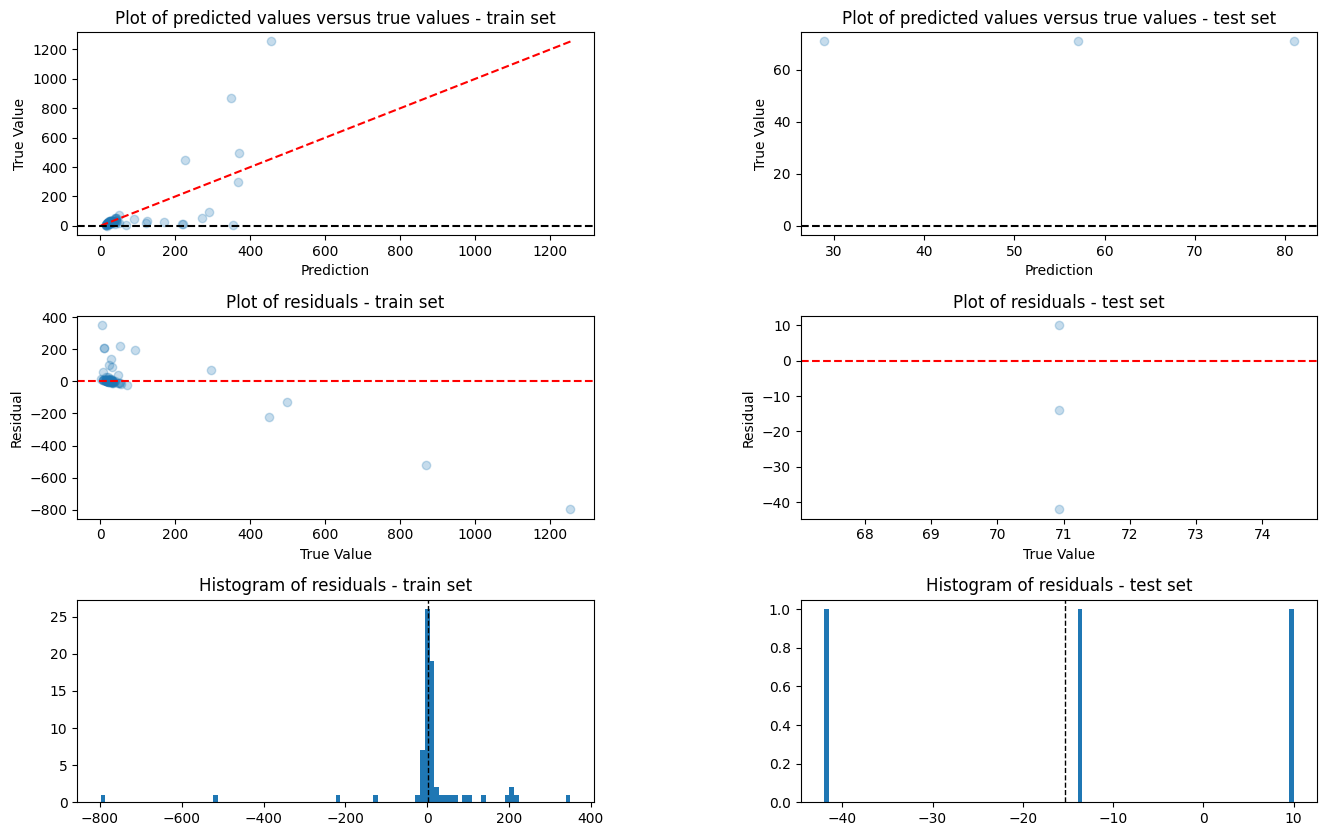

RMSE train: 136.53410442240812
DPA  train: 25.27523841295327
BIAS train: 4.06056834338258

RMSE test:  26.198333488579735
DPA  test: 69.00935809787767
BIAS test: -21.569973391264483


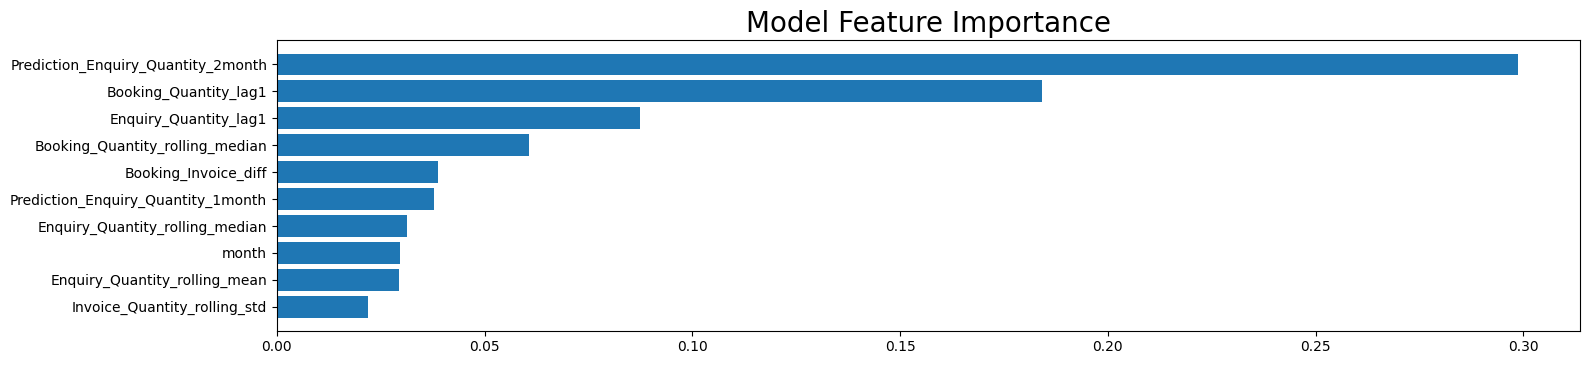

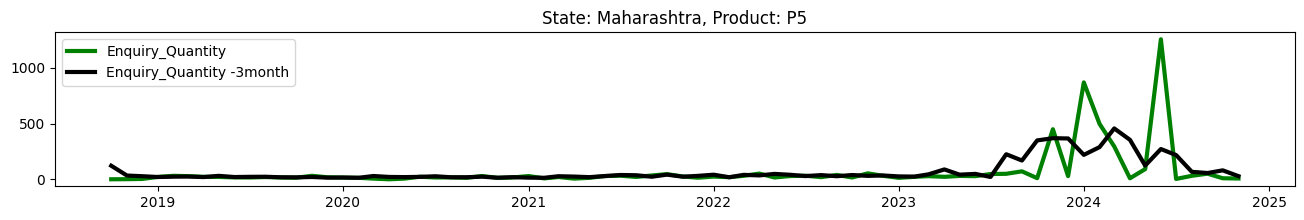

|---------------------------------	Booking_Quantity_1month	---------------------------------|
------------------------ Preparing Train Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Invoice_Quantity_rolling_median,Invoice_Quantity_rolling_std,Enquiry_Booking_diff,Booking_Invoice_diff,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month,Prediction_Enquiry_Quantity_3month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2018-10,1.0,0.0,0.0,68.972603,69.791667,70.056338,68.958904,69.75,70.028169,17.424658,...,0.0,7.780861,1.0,0.0,10,-8.660254e-01,0.500000,122.678902,49.314860,122.292150
2018-11,2.0,1.0,0.0,1.000000,69.791667,70.056338,0.000000,69.75,70.028169,0.000000,...,0.0,0.000000,1.0,1.0,11,-5.000000e-01,0.866025,45.502011,35.883036,34.465685
2018-12,4.0,3.0,0.0,2.000000,1.000000,70.056338,1.000000,0.00,70.028169,0.000000,...,0.0,0.000000,1.0,3.0,12,-2.449294e-16,1.000000,36.147382,30.620872,28.589633
2019-01,22.0,22.0,0.0,4.000000,2.000000,1.000000,3.000000,1.00,0.000000,0.000000,...,0.0,0.000000,0.0,22.0,1,5.000000e-01,0.866025,23.584870,25.822887,21.306420
2019-02,32.0,29.0,9.0,22.000000,4.000000,2.000000,22.000000,3.00,1.000000,0.000000,...,0.0,5.196152,3.0,20.0,2,8.660254e-01,0.500000,25.159711,23.805435,24.193974


YearMonth
2018-10     1.0
2018-11     3.0
2018-12    22.0
2019-01    29.0
2019-02    23.0
Freq: M, Name: Booking_Quantity_1month, dtype: float64

------------------------ Preparing Test Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Invoice_Quantity_rolling_median,Invoice_Quantity_rolling_std,Enquiry_Booking_diff,Booking_Invoice_diff,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month,Prediction_Enquiry_Quantity_3month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2024-09,51.0,50.0,16.0,32.0,4.0,1254.0,31.0,4.0,1258.0,10.0,...,16.0,17.009801,1.0,34.0,9,-1.000000,-1.836970e-16,158.728333,110.598332,57.022055
2024-10,10.0,12.0,12.0,51.0,32.0,4.0,50.0,31.0,4.0,16.0,...,12.0,3.055050,-2.0,0.0,10,-0.866025,5.000000e-01,60.622892,38.569260,80.952638
2024-11,8.0,6.0,6.0,10.0,51.0,32.0,12.0,50.0,31.0,12.0,...,12.0,5.033223,2.0,0.0,11,-0.500000,8.660254e-01,59.026813,18.744885,28.915567


YearMonth
2024-09    12.000000
2024-10     6.000000
2024-11    69.041096
Freq: M, Name: Booking_Quantity_1month, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
RandomForestRegressor(max_depth=5, min_samples_leaf=7, n_jobs=3,
                      random_state=123)

The best score: 
-49230.59736321345

The best parameters: 
{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 7, 'n_estimators': 100}


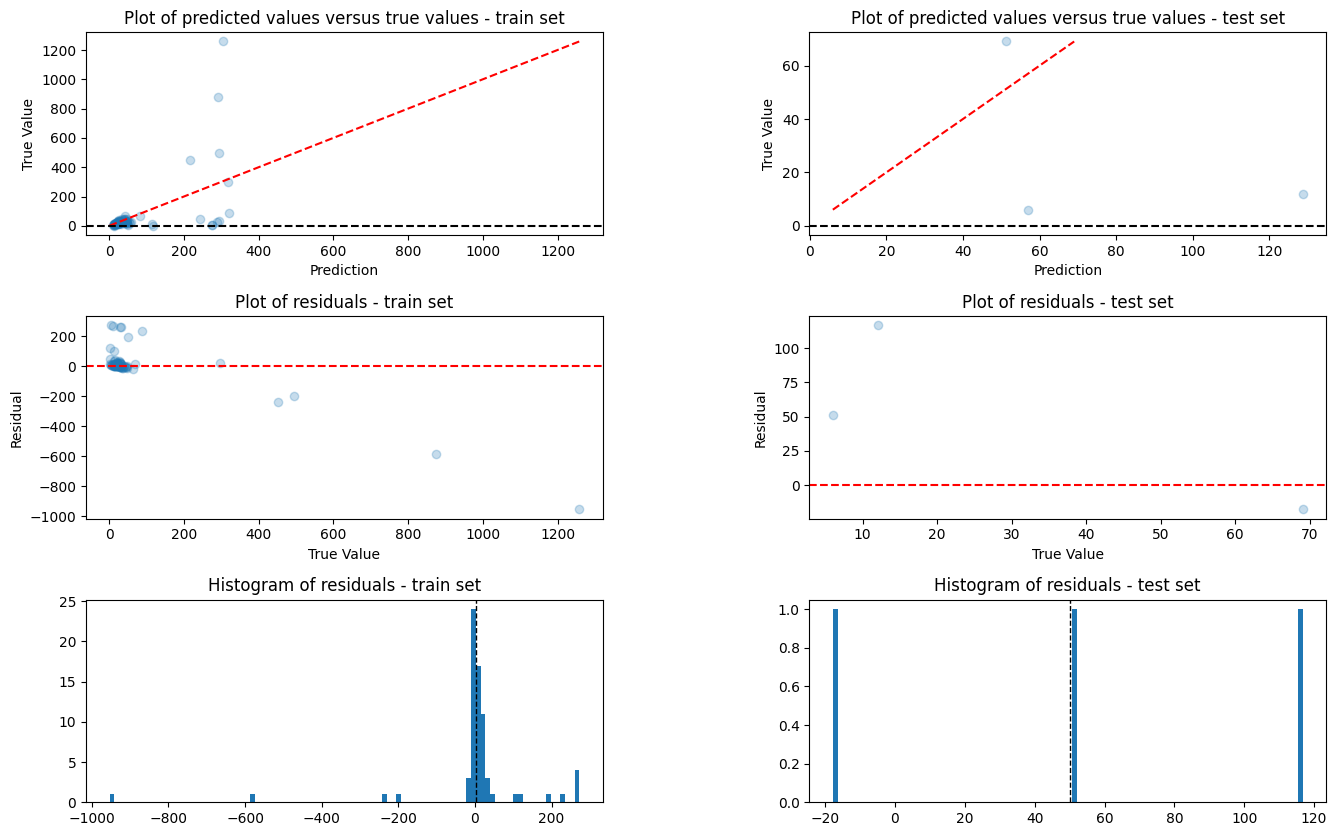

RMSE train: 157.27827484033622
DPA  train: 14.51077062479068
BIAS train: 2.5047578950724727

RMSE test:  74.24299846669257
DPA  test: -113.12278392221486
BIAS test: 172.23747778533203


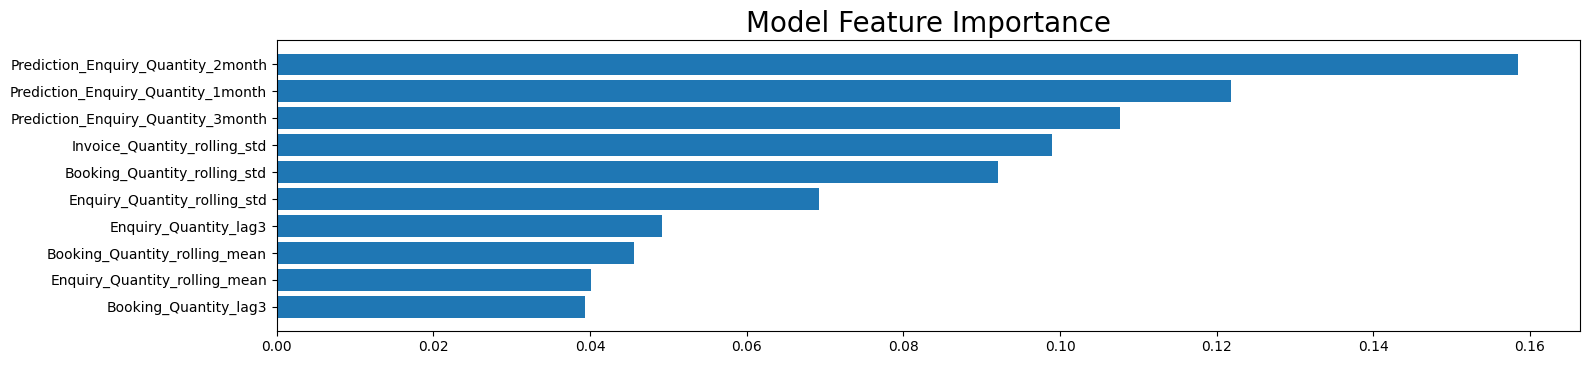

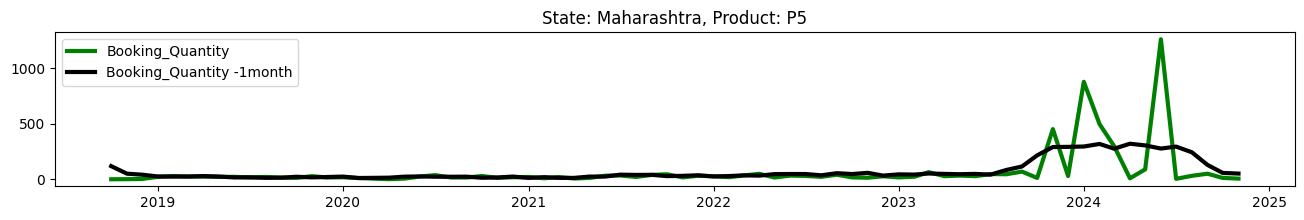

|---------------------------------	Booking_Quantity_2month	---------------------------------|
------------------------ Preparing Train Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Invoice_Quantity_rolling_std,Enquiry_Booking_diff,Booking_Invoice_diff,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month,Prediction_Enquiry_Quantity_3month,Prediction_Booking_Quantity_1month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2018-10,1.0,0.0,0.0,68.972603,69.791667,70.056338,68.958904,69.75,70.028169,17.424658,...,7.780861,1.0,0.0,10,-8.660254e-01,0.500000,122.678902,49.314860,122.292150,118.127162
2018-11,2.0,1.0,0.0,1.000000,69.791667,70.056338,0.000000,69.75,70.028169,0.000000,...,0.000000,1.0,1.0,11,-5.000000e-01,0.866025,45.502011,35.883036,34.465685,50.259935
2018-12,4.0,3.0,0.0,2.000000,1.000000,70.056338,1.000000,0.00,70.028169,0.000000,...,0.000000,1.0,3.0,12,-2.449294e-16,1.000000,36.147382,30.620872,28.589633,41.185989
2019-01,22.0,22.0,0.0,4.000000,2.000000,1.000000,3.000000,1.00,0.000000,0.000000,...,0.000000,0.0,22.0,1,5.000000e-01,0.866025,23.584870,25.822887,21.306420,25.225958
2019-02,32.0,29.0,9.0,22.000000,4.000000,2.000000,22.000000,3.00,1.000000,0.000000,...,5.196152,3.0,20.0,2,8.660254e-01,0.500000,25.159711,23.805435,24.193974,24.287268


YearMonth
2018-10     3.0
2018-11    22.0
2018-12    29.0
2019-01    23.0
2019-02    24.0
Freq: M, Name: Booking_Quantity_2month, dtype: float64

------------------------ Preparing Test Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Invoice_Quantity_rolling_std,Enquiry_Booking_diff,Booking_Invoice_diff,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month,Prediction_Enquiry_Quantity_3month,Prediction_Booking_Quantity_1month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2024-09,51.0,50.0,16.0,32.0,4.0,1254.0,31.0,4.0,1258.0,10.0,...,17.009801,1.0,34.0,9,-1.000000,-1.836970e-16,158.728333,110.598332,57.022055,128.688260
2024-10,10.0,12.0,12.0,51.0,32.0,4.0,50.0,31.0,4.0,16.0,...,3.055050,-2.0,0.0,10,-0.866025,5.000000e-01,60.622892,38.569260,80.952638,57.022638
2024-11,8.0,6.0,6.0,10.0,51.0,32.0,12.0,50.0,31.0,12.0,...,5.033223,2.0,0.0,11,-0.500000,8.660254e-01,59.026813,18.744885,28.915567,51.247587


YearMonth
2024-09     6.000000
2024-10    69.986111
2024-11    69.986111
Freq: M, Name: Booking_Quantity_2month, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
RandomForestRegressor(max_depth=10, min_samples_leaf=3, n_jobs=3,
                      random_state=123)

The best score: 
-41863.3936029045

The best parameters: 
{'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}


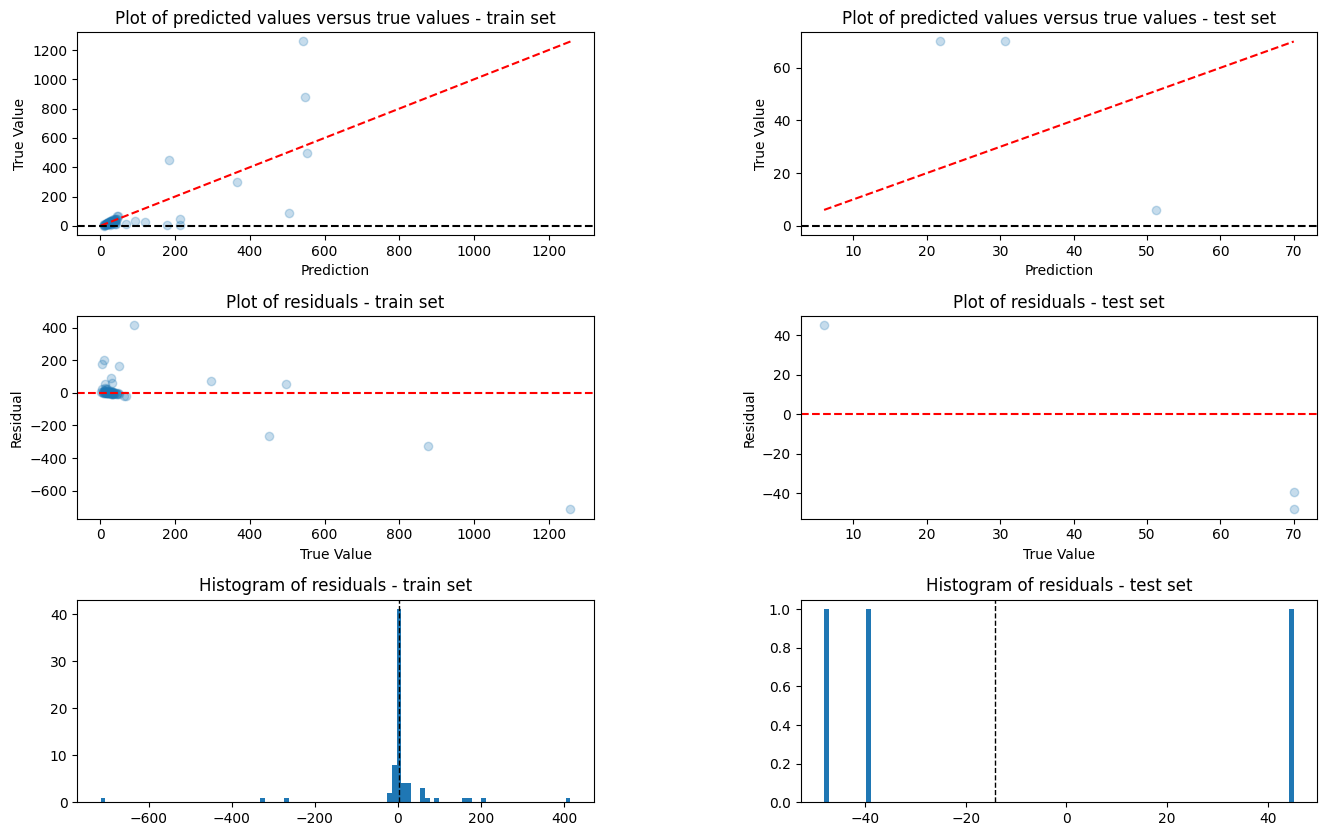

RMSE train: 118.08911959160584
DPA  train: 40.88174816992619
BIAS train: 2.985162228327344

RMSE test:  44.41449725657595
DPA  test: 9.028913712358076
BIAS test: -29.030480556550998


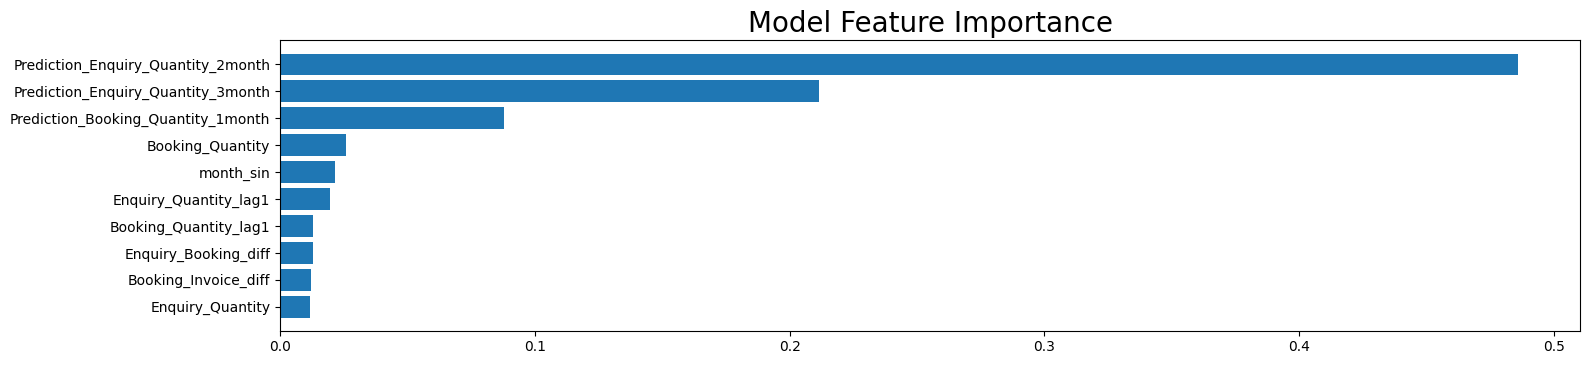

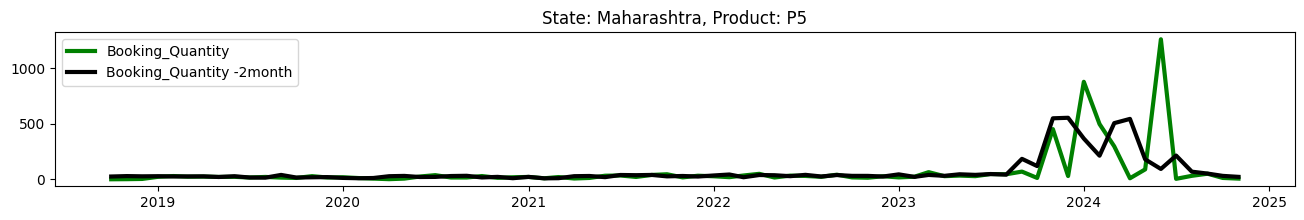

|---------------------------------	Booking_Quantity_3month	---------------------------------|
------------------------ Preparing Train Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Enquiry_Booking_diff,Booking_Invoice_diff,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month,Prediction_Enquiry_Quantity_3month,Prediction_Booking_Quantity_1month,Prediction_Booking_Quantity_2month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2018-10,1.0,0.0,0.0,68.972603,69.791667,70.056338,68.958904,69.75,70.028169,17.424658,...,1.0,0.0,10,-8.660254e-01,0.500000,122.678902,49.314860,122.292150,118.127162,24.890675
2018-11,2.0,1.0,0.0,1.000000,69.791667,70.056338,0.000000,69.75,70.028169,0.000000,...,1.0,1.0,11,-5.000000e-01,0.866025,45.502011,35.883036,34.465685,50.259935,28.697829
2018-12,4.0,3.0,0.0,2.000000,1.000000,70.056338,1.000000,0.00,70.028169,0.000000,...,1.0,3.0,12,-2.449294e-16,1.000000,36.147382,30.620872,28.589633,41.185989,26.587869
2019-01,22.0,22.0,0.0,4.000000,2.000000,1.000000,3.000000,1.00,0.000000,0.000000,...,0.0,22.0,1,5.000000e-01,0.866025,23.584870,25.822887,21.306420,25.225958,27.704549
2019-02,32.0,29.0,9.0,22.000000,4.000000,2.000000,22.000000,3.00,1.000000,0.000000,...,3.0,20.0,2,8.660254e-01,0.500000,25.159711,23.805435,24.193974,24.287268,25.282430


YearMonth
2018-10    22.0
2018-11    29.0
2018-12    23.0
2019-01    24.0
2019-02    21.0
Freq: M, Name: Booking_Quantity_3month, dtype: float64

------------------------ Preparing Test Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Enquiry_Booking_diff,Booking_Invoice_diff,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month,Prediction_Enquiry_Quantity_3month,Prediction_Booking_Quantity_1month,Prediction_Booking_Quantity_2month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2024-09,51.0,50.0,16.0,32.0,4.0,1254.0,31.0,4.0,1258.0,10.0,...,1.0,34.0,9,-1.000000,-1.836970e-16,158.728333,110.598332,57.022055,128.688260,51.208039
2024-10,10.0,12.0,12.0,51.0,32.0,4.0,50.0,31.0,4.0,16.0,...,-2.0,0.0,10,-0.866025,5.000000e-01,60.622892,38.569260,80.952638,57.022638,30.590211
2024-11,8.0,6.0,6.0,10.0,51.0,32.0,12.0,50.0,31.0,12.0,...,2.0,0.0,11,-0.500000,8.660254e-01,59.026813,18.744885,28.915567,51.247587,21.797534


YearMonth
2024-09    70.929577
2024-10    70.929577
2024-11    70.929577
Freq: M, Name: Booking_Quantity_3month, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
RandomForestRegressor(max_depth=5, min_samples_leaf=3, n_jobs=3,
                      random_state=123)

The best score: 
-42259.21688529462

The best parameters: 
{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100}


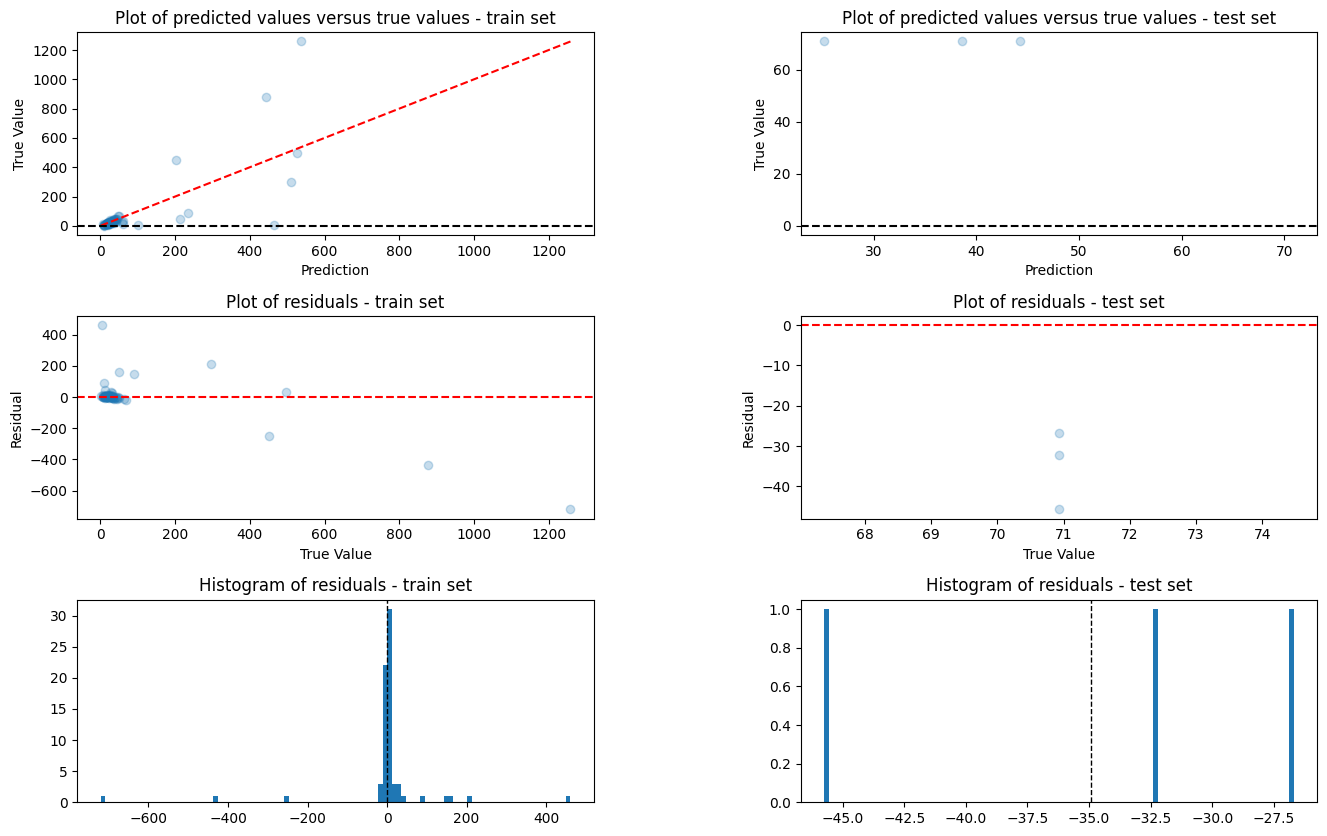

RMSE train: 123.85839630473748
DPA  train: 42.00184075811445
BIAS train: -1.995845983716028

RMSE test:  35.81115567090334
DPA  test: 50.78719975107251
BIAS test: -49.21280024892749


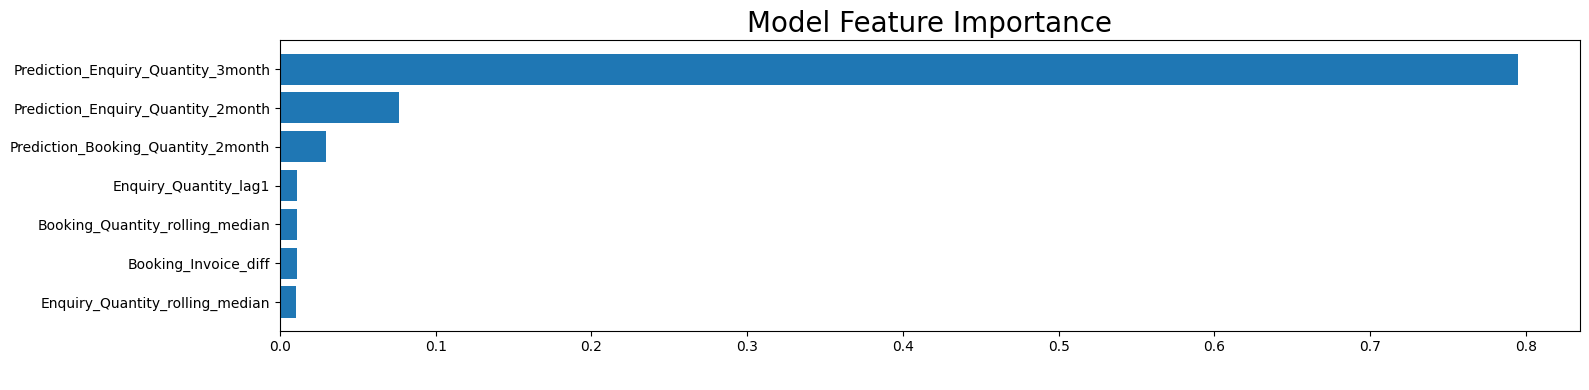

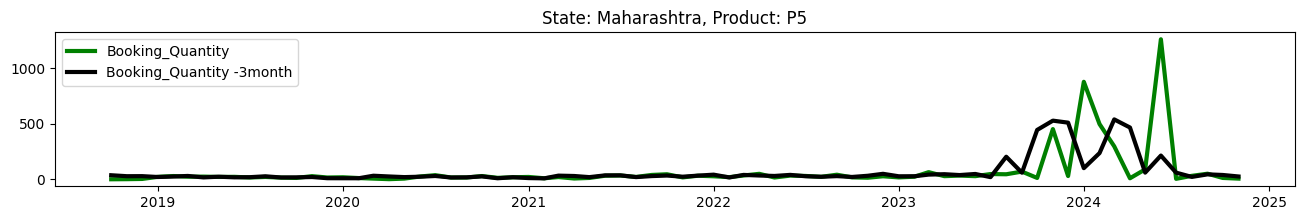

|---------------------------------	Invoice_Quantity_1month	---------------------------------|
------------------------ Preparing Train Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Booking_Invoice_diff,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month,Prediction_Enquiry_Quantity_3month,Prediction_Booking_Quantity_1month,Prediction_Booking_Quantity_2month,Prediction_Booking_Quantity_3month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2018-10,1.0,0.0,0.0,68.972603,69.791667,70.056338,68.958904,69.75,70.028169,17.424658,...,0.0,10,-8.660254e-01,0.500000,122.678902,49.314860,122.292150,118.127162,24.890675,36.334278
2018-11,2.0,1.0,0.0,1.000000,69.791667,70.056338,0.000000,69.75,70.028169,0.000000,...,1.0,11,-5.000000e-01,0.866025,45.502011,35.883036,34.465685,50.259935,28.697829,27.608904
2018-12,4.0,3.0,0.0,2.000000,1.000000,70.056338,1.000000,0.00,70.028169,0.000000,...,3.0,12,-2.449294e-16,1.000000,36.147382,30.620872,28.589633,41.185989,26.587869,28.187931
2019-01,22.0,22.0,0.0,4.000000,2.000000,1.000000,3.000000,1.00,0.000000,0.000000,...,22.0,1,5.000000e-01,0.866025,23.584870,25.822887,21.306420,25.225958,27.704549,20.452336
2019-02,32.0,29.0,9.0,22.000000,4.000000,2.000000,22.000000,3.00,1.000000,0.000000,...,20.0,2,8.660254e-01,0.500000,25.159711,23.805435,24.193974,24.287268,25.282430,24.718348


YearMonth
2018-10     0.0
2018-11     0.0
2018-12     0.0
2019-01     9.0
2019-02    16.0
Freq: M, Name: Invoice_Quantity_1month, dtype: float64

------------------------ Preparing Test Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,Booking_Invoice_diff,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month,Prediction_Enquiry_Quantity_3month,Prediction_Booking_Quantity_1month,Prediction_Booking_Quantity_2month,Prediction_Booking_Quantity_3month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2024-09,51.0,50.0,16.0,32.0,4.0,1254.0,31.0,4.0,1258.0,10.0,...,34.0,9,-1.000000,-1.836970e-16,158.728333,110.598332,57.022055,128.688260,51.208039,44.237742
2024-10,10.0,12.0,12.0,51.0,32.0,4.0,50.0,31.0,4.0,16.0,...,0.0,10,-0.866025,5.000000e-01,60.622892,38.569260,80.952638,57.022638,30.590211,38.650846
2024-11,8.0,6.0,6.0,10.0,51.0,32.0,12.0,50.0,31.0,12.0,...,0.0,11,-0.500000,8.660254e-01,59.026813,18.744885,28.915567,51.247587,21.797534,25.180850


YearMonth
2024-09    12.000000
2024-10     6.000000
2024-11    17.506849
Freq: M, Name: Invoice_Quantity_1month, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
RandomForestRegressor(max_depth=15, min_samples_leaf=3, n_jobs=3,
                      random_state=123)

The best score: 
-164.44421334052174

The best parameters: 
{'criterion': 'squared_error', 'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 100}


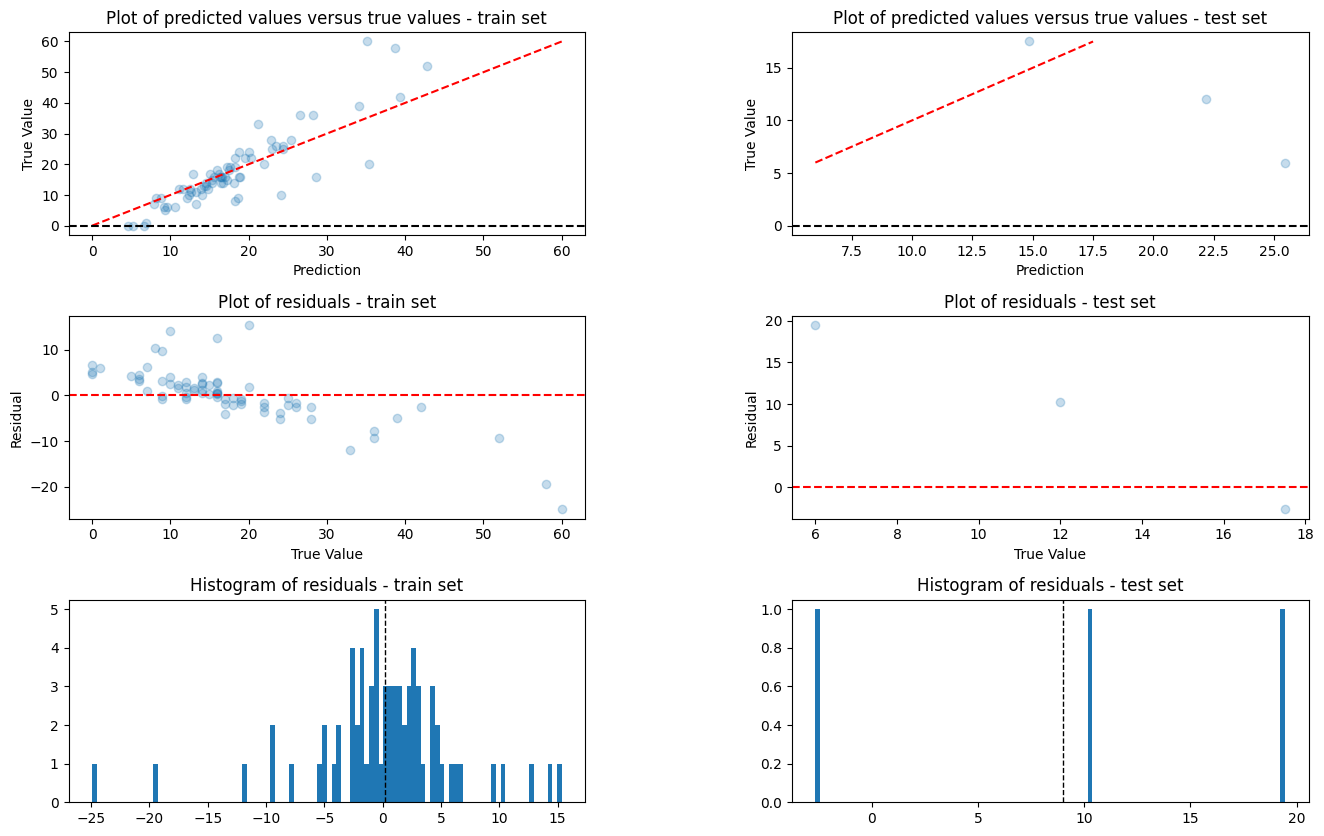

RMSE train: 6.149056252281296
DPA  train: 76.9869564121945
BIAS train: 1.2133961937533346

RMSE test:  12.778526393286453
DPA  test: 8.990750396508517
BIAS test: 76.09026494874294


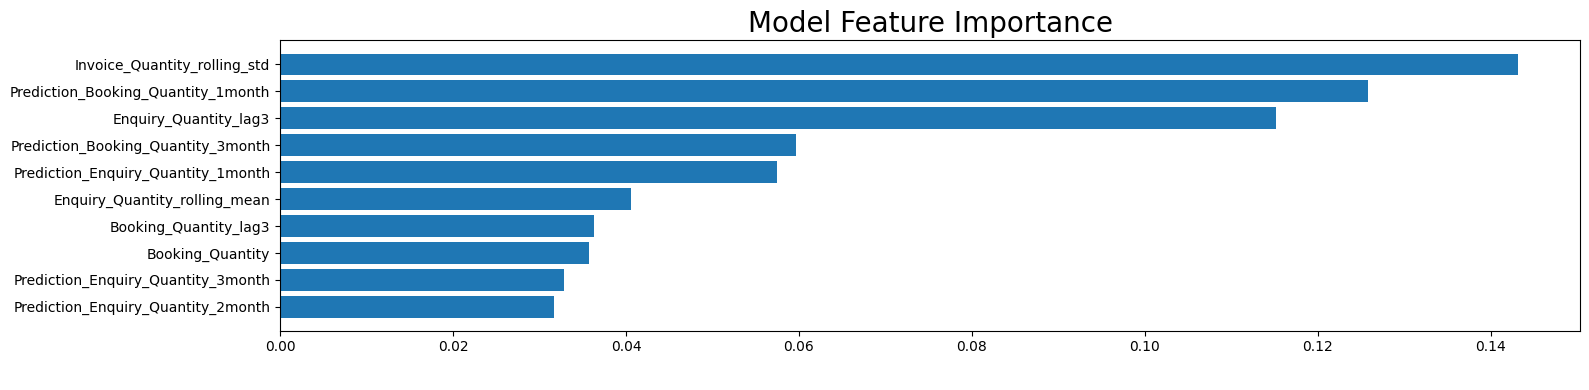

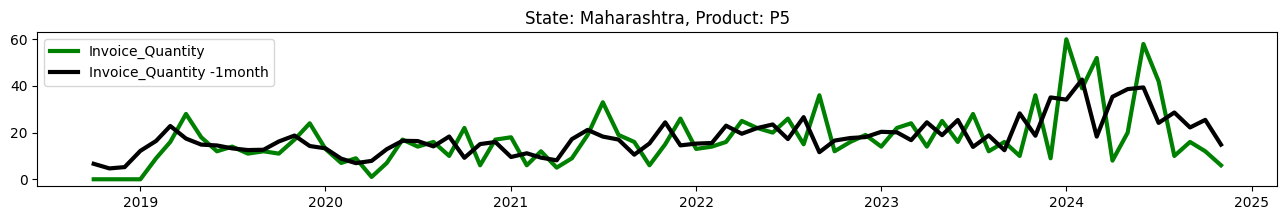

|---------------------------------	Invoice_Quantity_2month	---------------------------------|
------------------------ Preparing Train Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month,Prediction_Enquiry_Quantity_3month,Prediction_Booking_Quantity_1month,Prediction_Booking_Quantity_2month,Prediction_Booking_Quantity_3month,Prediction_Invoice_Quantity_1month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2018-10,1.0,0.0,0.0,68.972603,69.791667,70.056338,68.958904,69.75,70.028169,17.424658,...,10,-8.660254e-01,0.500000,122.678902,49.314860,122.292150,118.127162,24.890675,36.334278,6.634484
2018-11,2.0,1.0,0.0,1.000000,69.791667,70.056338,0.000000,69.75,70.028169,0.000000,...,11,-5.000000e-01,0.866025,45.502011,35.883036,34.465685,50.259935,28.697829,27.608904,4.656100
2018-12,4.0,3.0,0.0,2.000000,1.000000,70.056338,1.000000,0.00,70.028169,0.000000,...,12,-2.449294e-16,1.000000,36.147382,30.620872,28.589633,41.185989,26.587869,28.187931,5.218040
2019-01,22.0,22.0,0.0,4.000000,2.000000,1.000000,3.000000,1.00,0.000000,0.000000,...,1,5.000000e-01,0.866025,23.584870,25.822887,21.306420,25.225958,27.704549,20.452336,12.180972
2019-02,32.0,29.0,9.0,22.000000,4.000000,2.000000,22.000000,3.00,1.000000,0.000000,...,2,8.660254e-01,0.500000,25.159711,23.805435,24.193974,24.287268,25.282430,24.718348,16.426089


YearMonth
2018-10     0.0
2018-11     0.0
2018-12     9.0
2019-01    16.0
2019-02    28.0
Freq: M, Name: Invoice_Quantity_2month, dtype: float64

------------------------ Preparing Test Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,month,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month,Prediction_Enquiry_Quantity_3month,Prediction_Booking_Quantity_1month,Prediction_Booking_Quantity_2month,Prediction_Booking_Quantity_3month,Prediction_Invoice_Quantity_1month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2024-09,51.0,50.0,16.0,32.0,4.0,1254.0,31.0,4.0,1258.0,10.0,...,9,-1.000000,-1.836970e-16,158.728333,110.598332,57.022055,128.688260,51.208039,44.237742,22.205603
2024-10,10.0,12.0,12.0,51.0,32.0,4.0,50.0,31.0,4.0,16.0,...,10,-0.866025,5.000000e-01,60.622892,38.569260,80.952638,57.022638,30.590211,38.650846,25.460284
2024-11,8.0,6.0,6.0,10.0,51.0,32.0,12.0,50.0,31.0,12.0,...,11,-0.500000,8.660254e-01,59.026813,18.744885,28.915567,51.247587,21.797534,25.180850,14.858219


YearMonth
2024-09     6.00
2024-10    17.75
2024-11    17.75
Freq: M, Name: Invoice_Quantity_2month, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
RandomForestRegressor(max_depth=10, min_samples_leaf=3, n_jobs=3,
                      random_state=123)

The best score: 
-139.28286210115385

The best parameters: 
{'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}


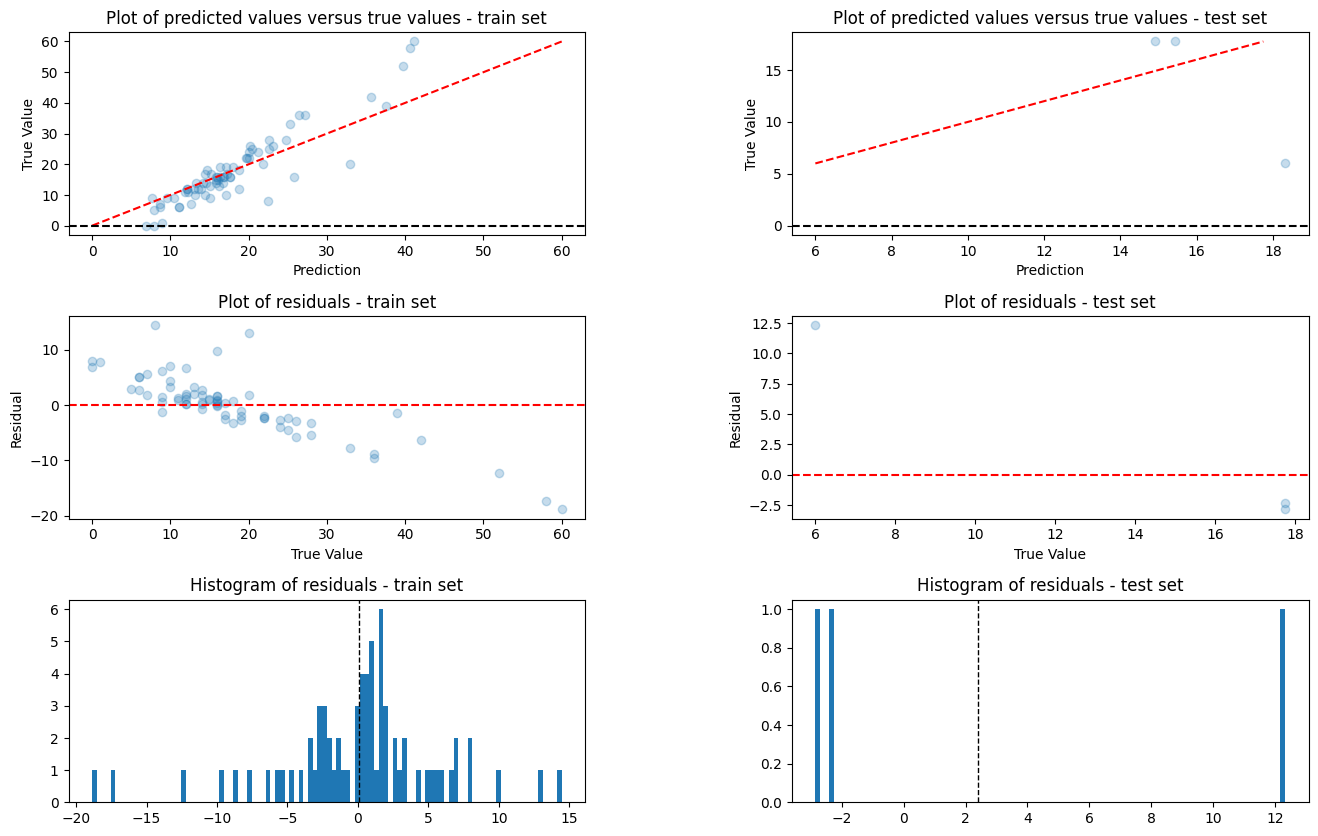

RMSE train: 5.599764147191992
DPA  train: 78.31884626118116
BIAS train: 0.3959077173699825

RMSE test:  7.4211020617492975
DPA  test: 57.88248578730503
BIAS test: 17.251337818807666


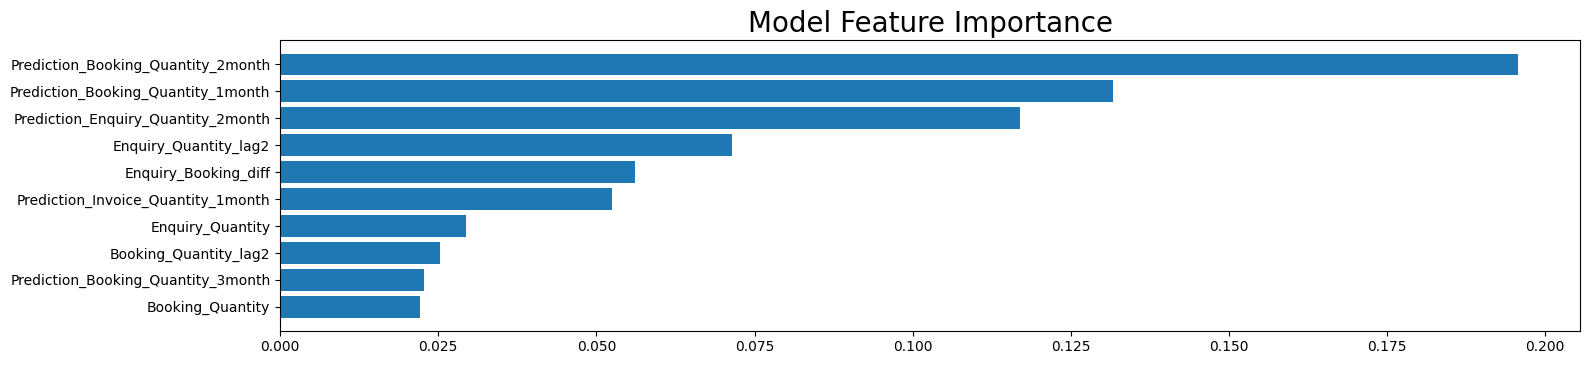

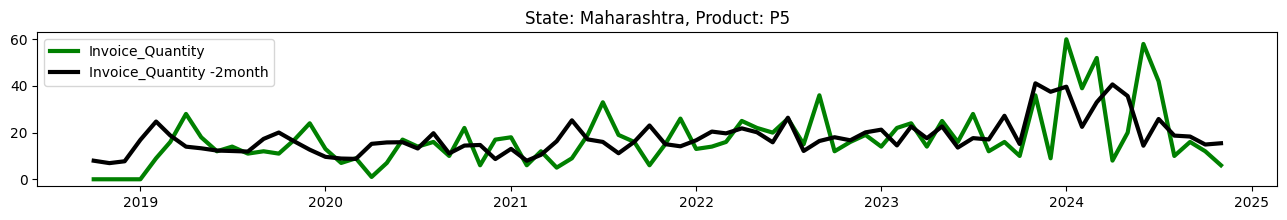

|---------------------------------	Invoice_Quantity_3month	---------------------------------|
------------------------ Preparing Train Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month,Prediction_Enquiry_Quantity_3month,Prediction_Booking_Quantity_1month,Prediction_Booking_Quantity_2month,Prediction_Booking_Quantity_3month,Prediction_Invoice_Quantity_1month,Prediction_Invoice_Quantity_2month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2018-10,1.0,0.0,0.0,68.972603,69.791667,70.056338,68.958904,69.75,70.028169,17.424658,...,-8.660254e-01,0.500000,122.678902,49.314860,122.292150,118.127162,24.890675,36.334278,6.634484,7.958322
2018-11,2.0,1.0,0.0,1.000000,69.791667,70.056338,0.000000,69.75,70.028169,0.000000,...,-5.000000e-01,0.866025,45.502011,35.883036,34.465685,50.259935,28.697829,27.608904,4.656100,6.922666
2018-12,4.0,3.0,0.0,2.000000,1.000000,70.056338,1.000000,0.00,70.028169,0.000000,...,-2.449294e-16,1.000000,36.147382,30.620872,28.589633,41.185989,26.587869,28.187931,5.218040,7.718727
2019-01,22.0,22.0,0.0,4.000000,2.000000,1.000000,3.000000,1.00,0.000000,0.000000,...,5.000000e-01,0.866025,23.584870,25.822887,21.306420,25.225958,27.704549,20.452336,12.180972,16.889070
2019-02,32.0,29.0,9.0,22.000000,4.000000,2.000000,22.000000,3.00,1.000000,0.000000,...,8.660254e-01,0.500000,25.159711,23.805435,24.193974,24.287268,25.282430,24.718348,16.426089,24.735873


YearMonth
2018-10     0.0
2018-11     9.0
2018-12    16.0
2019-01    28.0
2019-02    18.0
Freq: M, Name: Invoice_Quantity_3month, dtype: float64

------------------------ Preparing Test Set ------------------------


,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,...,month_sin,month_cos,Prediction_Enquiry_Quantity_1month,Prediction_Enquiry_Quantity_2month,Prediction_Enquiry_Quantity_3month,Prediction_Booking_Quantity_1month,Prediction_Booking_Quantity_2month,Prediction_Booking_Quantity_3month,Prediction_Invoice_Quantity_1month,Prediction_Invoice_Quantity_2month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2024-09,51.0,50.0,16.0,32.0,4.0,1254.0,31.0,4.0,1258.0,10.0,...,-1.000000,-1.836970e-16,158.728333,110.598332,57.022055,128.688260,51.208039,44.237742,22.205603,18.319037
2024-10,10.0,12.0,12.0,51.0,32.0,4.0,50.0,31.0,4.0,16.0,...,-0.866025,5.000000e-01,60.622892,38.569260,80.952638,57.022638,30.590211,38.650846,25.460284,14.897935
2024-11,8.0,6.0,6.0,10.0,51.0,32.0,12.0,50.0,31.0,12.0,...,-0.500000,8.660254e-01,59.026813,18.744885,28.915567,51.247587,21.797534,25.180850,14.858219,15.442333


YearMonth
2024-09    18.0
2024-10    18.0
2024-11    18.0
Freq: M, Name: Invoice_Quantity_3month, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
RandomForestRegressor(max_depth=5, min_samples_leaf=3, n_jobs=3,
                      random_state=123)

The best score: 
-154.31864934435185

The best parameters: 
{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100}


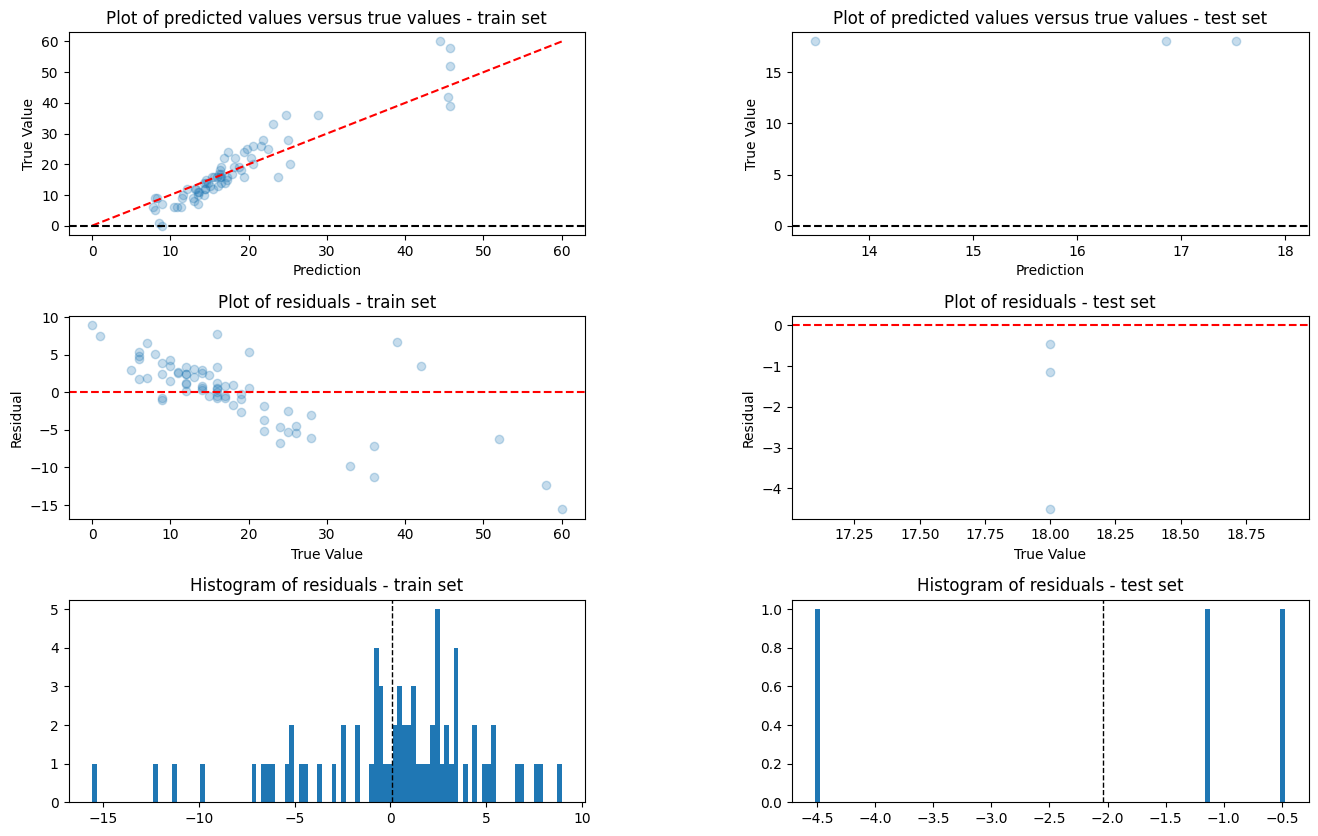

RMSE train: 4.6718700323887
DPA  train: 80.52247478112898
BIAS train: 0.5161846592077378

RMSE test:  2.7027956074347386
DPA  test: 88.64758634870667
BIAS test: -11.352413651293329


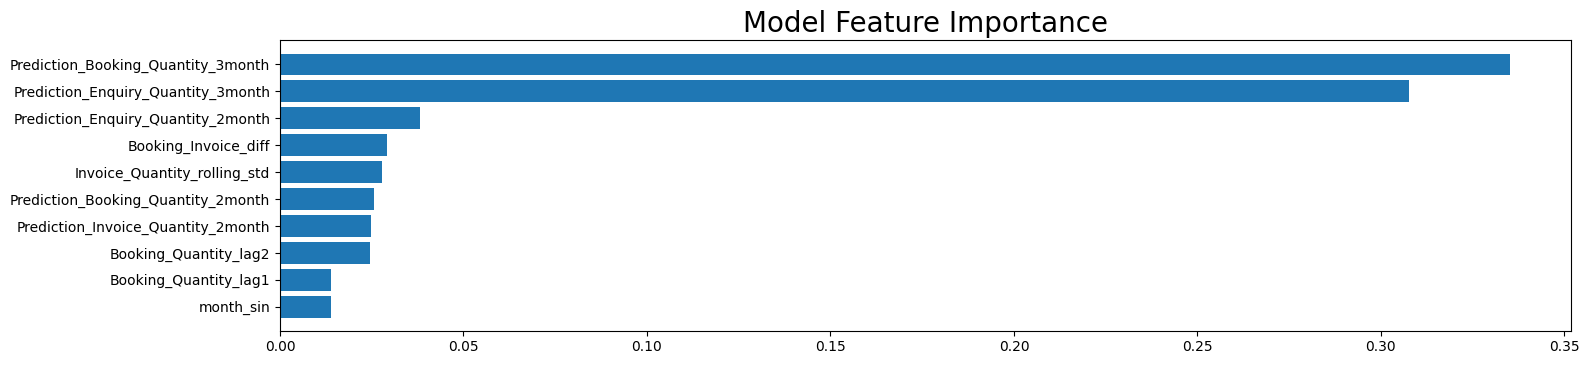

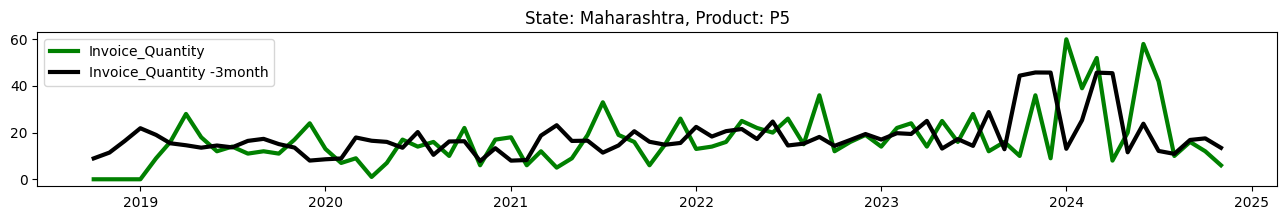

In [15]:
for horizon_prediction in target_columns:
    start_time = time.time()
    print(
        f"|---------------------------------\t{horizon_prediction}\t---------------------------------|"
    )
    if horizon_prediction[:16] == "Enquiry_Quantity":
        nr_horizon = int(horizon_prediction[17:18])
        type_prediction = "Enquiry_Quantity"
        target_name = "Enquiry_Quantity"
    elif horizon_prediction[:16] == "Booking_Quantity":
        nr_horizon = int(horizon_prediction[17:18])
        type_prediction = "Booking_Quantity"
        target_name = "Booking_Quantity"
    elif horizon_prediction[:16] == "Invoice_Quantity":
        nr_horizon = int(horizon_prediction[17:18])
        type_prediction = "Invoice_Quantity"
        target_name = "Invoice_Quantity"

    print("------------------------ Preparing Train Set ------------------------")
    train_set = modelling_mh_copy.loc[modelling_mh_copy.index < first_test_date, :]
    X_train = train_set.drop(columns=target_columns + ["KVA_Id", "StateName"]).copy()
    y_train = train_set[horizon_prediction].copy()

    display(X_train.head())
    display(y_train.head())

    # -------------------
    all_set = modelling_mh_copy.copy()
    X = all_set.drop(columns=target_columns + ["KVA_Id", "StateName"]).copy()
    y = all_set[horizon_prediction].copy()
    # ---------------------

    print("------------------------ Preparing Test Set ------------------------")
    test_set = modelling_mh_copy.loc[
        (modelling_mh_copy.index >= first_test_date)
        & (modelling_mh_copy.index <= end_test_date),
        :,
    ]
    X_test = test_set.drop(columns=target_columns + ["KVA_Id", "StateName"]).copy()
    y_test = test_set[horizon_prediction].copy()

    display(X_test.head())
    display(y_test.head())

    param_random_forest = {
        "max_depth": [5, 10, 15],
        "min_samples_leaf": [3, 7],
        "n_estimators": [100],
        "criterion": ["squared_error"],
    }
    RF = RandomForestRegressor(random_state=123, n_jobs=3)
    random_forest = GridSearchCV(
        RF,
        param_random_forest,
        cv=TimeSeriesSplit(n_splits=5).split(X_train),
        n_jobs=3,
        scoring="neg_mean_squared_error",
        verbose=10,
    )
    random_forest.fit(X_train, y_train)
    print(
        "The best estimator: ",
        random_forest.best_estimator_,
        "\nThe best score: ",
        random_forest.best_score_,
        "\nThe best parameters: ",
        random_forest.best_params_,
        sep="\n",
    )

    random_forest_model = random_forest.best_estimator_
    best_params = random_forest.best_params_

    all_set[f"Prediction_{type_prediction}_{nr_horizon}month"] = (
        random_forest_model.predict(X)
    )
    if X_train.isnull().any().any():
        print("X_train has missing values")
    if y_train.isnull().any().any():
        print("y_train has missing values")
    if X_test.isnull().any().any():
        print("X_test has missing values")
    if y_test.isnull().any().any():
        print("y_test has missing values")
    utilities.model_evaluation(
        model=random_forest_model,
        Xtrain=X_train,
        ytrain=y_train,
        Xtest=X_test,
        ytest=y_test,
    )

    modelling_mh_copy["YearMonth"] = (
        modelling_mh_copy.index
    )  # Preserve PeriodIndex in 'YearMonth'
    all_set["YearMonth"] = all_set.index  # Preserve PeriodIndex in 'YearMonth'

    modelling_mh_copy = modelling_mh_copy.reset_index(drop=True)
    all_set = all_set.reset_index(drop=True)

    modelling_mh_copy = pd.merge(
        modelling_mh_copy,
        all_set[
            [
                "StateName",
                "KVA_Id",
                f"Prediction_{type_prediction}_{nr_horizon}month",
                "YearMonth",
            ]
        ],
        how="left",
        on=[
            "StateName",
            "KVA_Id",
            "YearMonth",
        ],  # Merge on 'YearMonth' as well to match the time periods
    )
    # modelling_mh_copy["YearMonth"] = pd.to_datetime(
    #     modelling_mh_copy["YearMonth"], format="%Y-%m"
    # ).dt.to_period("M")

    # Set 'YearMonth' back as the index
    modelling_mh_copy = modelling_mh_copy.set_index("YearMonth")

    utilities.plot_true_pred(
        df=modelling_mh_copy,
        big_prod=biggest_products,
        number=4,
        target=target_name,
        type_pred=type_prediction,
        horizon=nr_horizon,
        scenario="",
    )

In [16]:
biggest_products.head()

,StateName,KVA_Id,Enquiry_Quantity
0,Maharashtra,P5,5043.0


In [17]:
type(modelling_mh_copy.index)

pandas.core.indexes.period.PeriodIndex

In [18]:
start_date = pd.to_datetime(modelling_mh_copy.index[0], format="%Y-%m-%d")
modelling_mh_copy.index = pd.period_range(
    start=start_date, periods=len(modelling_mh_copy), freq="M"
)

ValueError: time data "2018-10" doesn't match format "%Y-%m-%d", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [16]:
modelling_mh_copy.head()

,KVA_Id,StateName,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,...,Enquiry_Quantity_1month,Booking_Quantity_1month,Invoice_Quantity_1month,Enquiry_Quantity_2month,Booking_Quantity_2month,Invoice_Quantity_2month,Enquiry_Quantity_3month,Booking_Quantity_3month,Invoice_Quantity_3month,Prediction_Enquiry_Quantity_1month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2018-10,P5,Maharashtra,1.0,0.0,0.0,68.972603,69.791667,70.056338,68.958904,69.75,...,2.0,1.0,0.0,4.0,3.0,0.0,22.0,22.0,0.0,122.678902
2018-11,P5,Maharashtra,2.0,1.0,0.0,1.000000,69.791667,70.056338,0.000000,69.75,...,4.0,3.0,0.0,22.0,22.0,0.0,32.0,29.0,9.0,45.502011
2018-12,P5,Maharashtra,4.0,3.0,0.0,2.000000,1.000000,70.056338,1.000000,0.00,...,22.0,22.0,0.0,32.0,29.0,9.0,29.0,23.0,16.0,36.147382
2019-01,P5,Maharashtra,22.0,22.0,0.0,4.000000,2.000000,1.000000,3.000000,1.00,...,32.0,29.0,9.0,29.0,23.0,16.0,23.0,24.0,28.0,23.584870
2019-02,P5,Maharashtra,32.0,29.0,9.0,22.000000,4.000000,2.000000,22.000000,3.00,...,29.0,23.0,16.0,23.0,24.0,28.0,22.0,21.0,18.0,25.159711


In [27]:
all_set.head()

,KVA_Id,StateName,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,...,Enquiry_Quantity_1month,Booking_Quantity_1month,Invoice_Quantity_1month,Enquiry_Quantity_2month,Booking_Quantity_2month,Invoice_Quantity_2month,Enquiry_Quantity_3month,Booking_Quantity_3month,Invoice_Quantity_3month,Prediction_Enquiry_Quantity_1month
YearMonth,,,,,,,,,,,,,,,,,,,,,
2018-10,P5,Maharashtra,1.0,0.0,0.0,68.972603,69.791667,70.056338,68.958904,69.75,...,2.0,1.0,0.0,4.0,3.0,0.0,22.0,22.0,0.0,122.678902
2018-11,P5,Maharashtra,2.0,1.0,0.0,1.000000,69.791667,70.056338,0.000000,69.75,...,4.0,3.0,0.0,22.0,22.0,0.0,32.0,29.0,9.0,45.502011
2018-12,P5,Maharashtra,4.0,3.0,0.0,2.000000,1.000000,70.056338,1.000000,0.00,...,22.0,22.0,0.0,32.0,29.0,9.0,29.0,23.0,16.0,36.147382
2019-01,P5,Maharashtra,22.0,22.0,0.0,4.000000,2.000000,1.000000,3.000000,1.00,...,32.0,29.0,9.0,29.0,23.0,16.0,23.0,24.0,28.0,23.584870
2019-02,P5,Maharashtra,32.0,29.0,9.0,22.000000,4.000000,2.000000,22.000000,3.00,...,29.0,23.0,16.0,23.0,24.0,28.0,22.0,21.0,18.0,25.159711


In [21]:
prod = (modelling_mh_copy[["StateName", "KVA_Id"]] == biggest_products.iloc[0, :2]).all(
    axis=1
)

In [23]:
modelling_mh_copy.index[prod]

PeriodIndex(['2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03',
             '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09',
             '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03',
             '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
             '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03',
             '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
             '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
             '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
             '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
             '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
             '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03',
             '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09',
             '2024-10', '2024-11'],
            dtyp

In [22]:
prod

YearMonth
2018-10    True
2018-11    True
2018-12    True
2019-01    True
2019-02    True
           ... 
2024-07    True
2024-08    True
2024-09    True
2024-10    True
2024-11    True
Freq: M, Length: 74, dtype: bool

In [25]:
modelling_mh_copy.loc[prod, target_name]

YearMonth
2018-10     1.0
2018-11     2.0
2018-12     4.0
2019-01    22.0
2019-02    32.0
           ... 
2024-07     4.0
2024-08    32.0
2024-09    51.0
2024-10    10.0
2024-11     8.0
Freq: M, Name: Enquiry_Quantity, Length: 74, dtype: float64

In [ ]:
modelling_mh_copy